In [1]:
from __future__ import division, print_function

import numpy as np
from scipy.optimize import fmin
from scipy.spatial.distance import squareform, pdist, cdist


import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def get_data(path, return_analytic=False):
    x,_16,_50,_84 = [],[],[],[]
    analytic = []
    
    hit_analytic = False
    with open(path, 'r') as f:
        for line in f.readlines():
            if 'analytic' in line:
                hit_analytic=True
                if return_analytic:
                    continue
                else:
                    break
            
            if hit_analytic == False:
                vals = line.strip().split()
                if len(vals) == 0:
                    break

                x.append(float(vals[0]))            
                _16.append(float(vals[1]))
                _50.append(float(vals[2]))
                _84.append(float(vals[3]))
            else:
                vals = line.replace('0.0','').replace('[','').replace(']','').replace(',','').strip().split()
                print(vals)
                analytic = [float(v) for v in vals]
    
    if return_analytic:
        return tuple([np.array(v) for v in [x,_16,_50,_84,analytic]])
    else:
        return tuple([np.array(v) for v in [x,_16,_50,_84]])

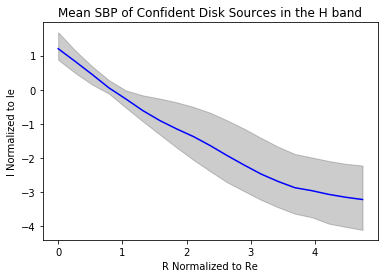

In [3]:
x, y16, y50, y84 = get_data('_orig_images_ClDk_h.csv')

y16 = np.log(y16)
y50 = np.log(y50)
y84 = np.log(y84)

#plt.yscale('log')
plt.plot(x,y50, color='b')
plt.title('Mean SBP of Confident Disk Sources in the H band')
plt.xlabel('R Normalized to Re')
plt.ylabel('I Normalized to Ie')
plt.fill_between(x, y_16, y_84, alpha=0.2, color='k')

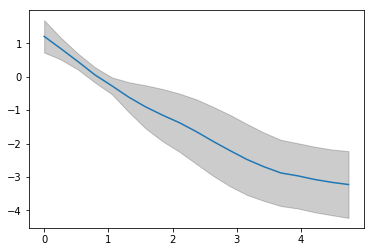

In [6]:
std = y_84-y_50
plt.plot(x,y_50)
plt.fill_between(x, y_50-std, y_50+std, alpha=0.2, color='k')

In [7]:
std = np.diag(std)

$K = [k(x_1,x^'_1)...k(x_n,x'_n)]$

$K_* = [k(x_*, x_1), .., k(x_*,x_n )]$

$K_{**}=k(x_*,x_*)$


In [8]:

sigma_n  = []
for i in range(len(y_50)):
    sigma_n.append((y_84[i]-y_50[i])/2.0)
sigma_n = np.array(sigma_n).mean()
sigma_n = std

#from  scratch
def kronecker_delta(a,b):
    return np.equal(a,b).astype(np.int)

def squared_exponential(x, y, sigma_f, length):
    return sigma_f**2 * np.exp(-(x-y)**2/(2*(length**2)))

def kernel(x, _x, sigma_n, sigma_f, length, with_sigma=False):
    if with_sigma:
        return squared_exponential(x,_x,sigma_f,length) + sigma_n * kronecker_delta(x,_x)
    else:
        return squared_exponential(x,_x,sigma_f,length)

def build_cov(x,_x, sigma_n, sigma_f,length, with_sigma=False):
    cov = []
    for i in range(len(x)):
        cov.append(np.array([kernel(x[i],_x[j],sigma_n,sigma_f,length, with_sigma) for j in range(len(_x))]))

    return np.array(cov)
    
def log_likelihood(theta):
    sigma_f, length = theta
    
    y = y_50
    
    #cov = build_cov(x, sigma_n, sigma_f, length)
    cov = build_cov(x, x, sigma_n, sigma_f, length, with_sigma=True)
    
    return -(-0.5*y.T.dot(np.linalg.inv(cov)).dot(y)-0.5*np.log(np.linalg.det(cov))-len(y)*0.5*np.log(2.0*np.pi))

sigma_n

array([[ 0.4826718 ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.3227408 ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.23882135,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ,  0.22733898,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         0.   

In [15]:
length = 1.0
sigma_f = 1.0

theta = [sigma_f,length]

result = fmin(log_likelihood, theta)

sigma_f, length = result[0], result[1]
print(sigma_f, length)

Optimization terminated successfully.
         Current function value: 22.023879
         Iterations: 45
         Function evaluations: 87
2.54150654217 3.49624847624


In [7]:

print(sigma_n,sigma_f,length)

NameError: name 'sigma_f' is not defined

In [9]:
_x = [i for i in np.linspace(0,4,15) if i not in x]

In [10]:
cov_f = lambda a,b: build_cov(a,b,sigma_n,sigma_f,length)
cov_fn = lambda a,b: build_cov(a,b,sigma_n,sigma_f,length,with_sigma=True)


mean_f = cov_f(_x,x).dot(np.linalg.inv(cov_fn(x,x))).dot(y_50)
var = cov_f(_x,_x)-cov_f(_x,x).dot(np.linalg.inv(cov_fn(x,x))).dot(cov_f(x,_x))

var = np.diagonal(var)
print(var)
print(_x)


[ 0.17080154  0.12771928  0.1021792   0.08916704  0.0842239   0.08365848
  0.08468138  0.08547866  0.0852453   0.08419622  0.08356357  0.08557794
  0.09342048  0.11112625]
[0.2857142857142857, 0.5714285714285714, 0.8571428571428571, 1.1428571428571428, 1.4285714285714284, 1.7142857142857142, 2.0, 2.2857142857142856, 2.5714285714285712, 2.8571428571428568, 3.1428571428571428, 3.4285714285714284, 3.714285714285714, 4.0]


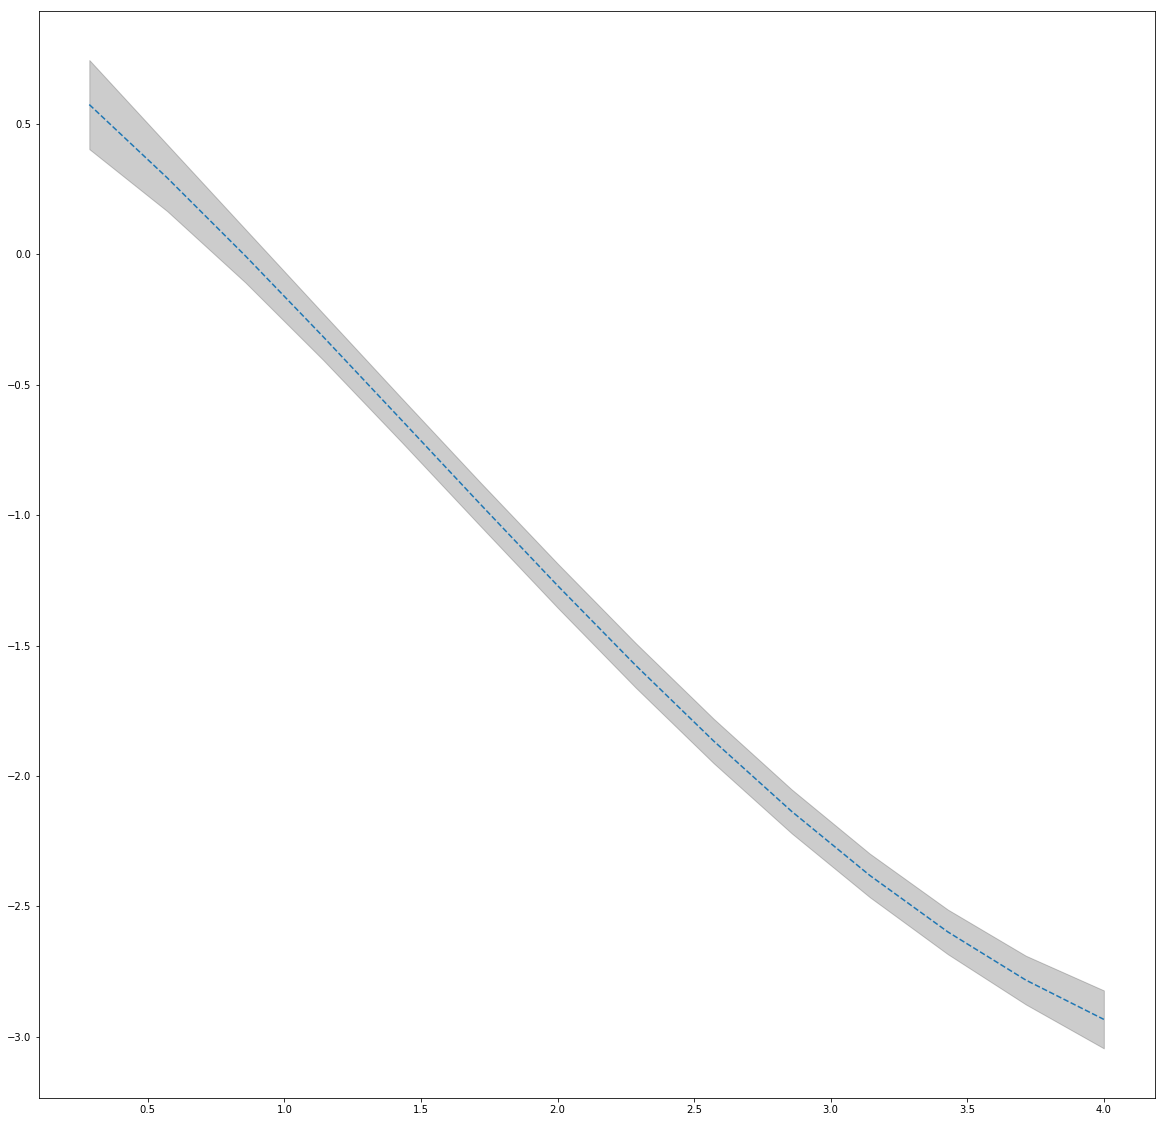

In [11]:
plt.figure(figsize=(20data:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABI0AAARiCAYAAAAp2gdjAAAABHNCSVQICAgIfAhkiAAAAAlwSFlzAAALEgAACxIB0t1+/AAAIABJREFUeJzs3Xt0nPd93/nP75krBpj7DCReRFHiVaQokiJIAKRlyW2ziTdpk91mc+nutulpc23SJCdJm25sXWzHTduTNHGbddbtbtImOU3TbZrjdLNxna0p20mswQAERBICTBEgKZAiZgAMrjPAYGae/UOkKgmyTInPZQC8X+foHFPC+X2/oiX98T7P83uMbdsCAAAAAAAA3sryewEAAAAAAAC0H6IRAAAAAAAANiAaAQAAAAAAYAOiEQAAAAAAADYgGgEAAAAAAGADohEAAAAAAAA2IBoBAAAAAABgA6IRAAAAAAAANiAaAQAAAAAAYAOiEQAAAAAAADYI+r3Ae8nlcvbevXv9XgMAAAAAAGDLGBwcnLFtO//Nfq6to9HevXtVLBb9XgMAAAAAAGDLMMZcv5ef4/U0AAAAAAAAbEA0AgAAAAAAwAZEIwAAAAAAAGxANAIAAAAAAMAGRCMAAAAAAABsQDQCAAAAAADABkQjAAAAAAAAbEA0AgAAAAAAwAZEIwAAAAAAAGxANAIAAAAAAMAGRCMAAAAAAABsQDQCAAAAAADABkQjAAAAAAAAbEA0AgAAAAAAwAZEIwAAAAAAAGxANAIAAAAAAMAGRCMAAAAAAABsQDQCAAAAAADABkQjAAAAAAAAbEA0AgAAAAAAwAZEIwAAAAAAAGxANAIAAAAAAMAGRCMAAAAAAABsQDQCAAAAAADABkQjAAAAAAAAbEA0AgAAAAAAwAZEIwAAAAAAAGxANAIAAAAAAMAGRCMAAAAAAABsQDQCAAAAAADABkQjAAAAAAAAbEA0AgAAAAAAwAZEIwAAAAAAAGxANAIAAAAAAMAGRCMAAAAAAABsQDQCAAAAAADABkQjAAAAAAAAbEA0AgAAAAAAwAZEIwAAAAAAAGxANAIAAAAAAMAGRCMAAAAAAABsQDQCAAAAAADABkQjAAAAAAAAbEA0AgAAAAAAwAZEIwAAAAAAAGxANAIAAAAAAMAGRCMAAAAAAABsQDTywOTkpF5//XW/1wAAAAAAALhnRCMPLC8vq1AoqFwu+70KAAAAAADAPSEaeaSjo0PFYlHz8/N+rwIAAAAAAPBNEY08EolElEgkVCgUtLS05Pc6AAAAAAAA74lo5KFoNKqOjg4VCgVVq1W/1wEAAAAAAPiGiEYei8ViCgQCGhgY0Orqqt/rAAAAAAAAvCuikQ/i8biazaYGBwdVr9f9XgcAAAAAAGADopFPksmkqtWqhoeH1Wg0/F4HAAAAAADgbYhGPspkMqpUKhoZGVGz2fR7HQAAAAAAgDcRjXyWy+VUKpU0Ojoq27b9XgcAAAAAAEAS0agt5PN5TU1NaWxsjHAEAAAAAADaAtGoDRhjlM/nNTk5qYmJCb/XAQAAAAAAIBq1i7vhaGxsTDdu3PB7HQAAAAAAsM0RjdqIZVnK5XK6ePGibt++7fc6AAAAAABgGyMatZlgMKhsNquhoSHNzMz4vQ4AAAAAANimiEZtKBQKKZVKqVgsan5+3u91AAAAAADANkQ0alORSETxeFwDAwNaWlryex0AAAAAALDNEI3aWDQaVSQS0cDAgKrVqt/rAAAAAACAbYRo1OY6OztlWZYGBga0urrq9zoAAAAAAGCbIBptAvF4XM1mU4ODg6rX636vAwAAAAAAtgGi0SaRTCZVrVY1PDysRqPh9zoAAAAAAGCLIxptIplMRvPz87p48aJarZbf6wAAAAAAgC2MaLTJZLNZ3b59W6Ojo7Jt2+91AAAAAADAFkU02oTy+bxu3Lih8fFxwhEAAAAAAHAF0WgTMsYon8/r6tWrmpyc9HsdAAAAAACwBRGNNinLspTP5/XKK69oamrK73UAAAAAAMAWQzTaxAKBgHK5nF5++WXdvn3b73UAAAAAAMAWQjTa5ILBoDKZjC5cuKDZ2Vm/1wEAAAAAAFsE0WgLCIVCSiaTGhgY0MLCgt/rAAAAAACALYBotEVEIhF1dXWpUChoeXnZ73UAAAAAAMAmRzTaQjo6OhQOh1UoFFStVv1eBwAAAAAAbGJEoy2mq6tLxhgVi0Wtra35vQ4AAAAAANikiEZbUCKR0Pr6uorFotbX1/1eBwAAAAAAbEJEoy0qlUqpWq1qZGREjUbD73UAAAAAAMAmQzTawjKZjGZnZ3Xx4kW1Wi2/1wEAAAAAAJsI0WiLy+Vyev311/XKK6/Itm2/1wEAAAAAAJsE0Wgb6O7u1vXr1/X1r3+dcAQAAAAAAO4J0WgbMMYon8/r6tWrmpyc9HsdAAAAAACwCRCNtgnLspTL5fTKK69oamrK73UAAAAAAECbIxptI4FAQLlcTiMjI5qenvZ7HQAAAAAA0MaIRttMMBhUNpvV0NCQ5ubm/F4HAAAAAAC0KaLRNhQKhZRMJjUwMKCFhQW/1wEAAAAAAG2IaLRNRSIRdXZ2qlAoaHl52e91AAAAAABAmyEabWMdHR0Kh8MaGBhQrVbzex0AAAAAANBGiEYua7Vs/Yuvzeql19f9XuVddXV1SZKKxaLW1tZ83gYAAAAAALQLopHLVhtN3Vxq6LPDa/riRNXvdd5VIpFQvV7X0NCQ1tfbM24BAAAAAABvEY1cFgsH9fxH8jqWD+g3Bhf1+fEVv1d6V6lUSsvLyxoZGVGz2fR7HQAAAAAA4DOikQeiQUs/+WRU/buj+jcvL+n3R9vz4ulMJqPZ2VldunRJrVbL73UAAAAAAICPgn4vsF0ELaOf7ksqPmT0cLJ9f9tzuZxu3bqlUCikxx57TMYYv1cCAAAAAAA+aN96sQUFjNEPn0q++euxmboOZEIKWO0VZvL5vK5du6ZgMKiDBw/6vQ4AAAAAAPABr6f55NZSQx8/P6df/tq81pu23+u8jTFG+XxeV65c0bVr1/xeBwAAAAAA+IBo5JOd8aD+1vG4Xrq5pn/8ZxWtNtrrDiHLspTP53X58mXdvHnT73UAAAAAAIDHiEY++o4DnfqxnoQuTtf1yS9XtFJvr3AUCASUy+U0MjKiUqnk9zoAAAAAAMBDRCOf/eVHYvrpvpRenVvXFydrfq+zQTAYVDqdVrFY1NzcnN/rAAAAAAAAj3ARdhs4+1BUO+LZN7+qZtt2W321LBwOK5lMamBgQP39/UokEn6vBAAAAAAAXMaTRm3ikVRIljEqrTT0sS/N6dZSw++V3iYajaqzs1MvvfSSlpeX/V4HAAAAAAC4jGjUZpbr9htfVvvSnK4vrPu9ztt0dHQoHA5rYGBAtVr7vUoHAAAAAACcQzRqM4+mQ/rkR7KyLOnZL83p67N1v1d6m66uLtm2rWKxqLW1Nb/XAQAAAAAALiEataHdiaB+8SMZdYUtvfBiRWMz7RWOksmk6vW6hoaGtL7eXk9DAQAAAAAAZxCN2lR3Z1Cf+khGJ3eEtTPefveVp1IpLS0taWRkRM1m0+91AAAAAACAwxyJRsaYbzPGjBtjXjXG/Py7/PVnjDELxpjhO38868TcrS7dEdDP9qeViFhab9l6ebq9XgfLZrOamZnRpUuX1Gq1/F4HAAAAAAA46L4fYTHGBCT9uqRvkTQlacAY83nbtkff8aNfsW37O+533nb1+fEV/btLy/rBJxP61n0xv9d5Uz6f182bNxUKhfTYY4/JGOP3SgAAAAAAwAFOPGl0RtKrtm1P2LZdl/R7kr7TgXPxFt9xsFNP7ojoc0OL+k9j7fXJ++7ubl27dk1XrlzxexUAAAAAAOAQJ6LRLkmvveXXU3f+3DudNca8bIz5f40xRx2Yu61EAkb/4GxK5x6K6ncuLut3Ly7Jtm2/15IkGWOUz+d15coVXbt2ze91AAAAAACAA7y6CHtI0h7btp+Q9C8k/eE3+kFjzA8ZY4rGmGK5XPZovc0haBn9ZG9S3/Joh/7zlRW9vtw+F1BblqV8Pq/Lly/r5s2bfq8DAAAAAADukxPR6Kakh97y6913/tybbNtetG17+c7//mNJIWNM7t0Os237c7Zt99i23ZPP5x1Yb2sJGKMffjKhf/ZXcm9+Va1dnjgKBALK5XIaGRlRqVTyex0AAAAAAHAfnIhGA5IOGGMeMcaEJX2fpM+/9QeMMQ+aOzckG2PO3Jk768DsbckYo92JN4LRFyeq+qd/Pq96sz3CUTAYVDqdVrFYVKVS8XsdAAAAAADwAd13NLJtuyHpxyV9QdIrkn7ftu3LxpgfMcb8yJ0f+25Jl4wxI5I+I+n77HZ5PGaTa7RsFW6t6dNfrajWaI/P3ofDYSWTSRUKBS0uLvq9DgAAAAAA+ABMO7ebnp4eu1gs+r3Gfbt48aLm5ubU1dXlyvnnr9X06wML2p8J6ReeSqsr7NVVVe+tWq1qbW1N/f396uzs9HsdAAAAAAAgyRgzaNt2zzf7ufaoC7gvz+zt0M+eTWlifl3Pnp/Taps8cRSLxRQKhTQwMKBareb3OgAAAAAA4H0gGm0Rvbui+t8+lNbpnRFFAsbvdd7U1dWlVquloaEh1et1v9cBAAAAAAD3iGi0hRx/IKLvfzwuY4yuza/r5lLD75UkSclkUrVaTUNDQ1pfX/d7HQAAAAAAcA+IRltQy7b1a4UFfexLc5qcb49Ik06ntbi4qJdfflnNZtPvdQAAAAAAwDdBNNqCLGP0s/0phSzp2fNzGptpj9fCstmsSqWSLl26pFarPe5dAgAAAAAA745otEXtigf1qY9klYhY+sSXKxqZXvN7JUlSd3e3bt68qfHxcbXzl/sAAAAAANjuiEZbWHdnQJ/6SEYPdgX0B6+stE2k6e7u1sTEhK5ever3KgAAAAAA4BsI+r0A3JWOBvSJZzKSJGOMmratgPH362rGGHV3d2t8fFyhUEgPP/ywr/sAAAAAAICNeNJoG+gKW+oKW1pr2vrklyv6k1erfq8ky7KUy+V06dIl3bp1y+91AAAAAADAOxCNthEjKRo0+lcXFvUHryz7/rpaMBhULpfT8PCwyuWyr7sAAAAAAIC3IxptI+HAG19V+/CeqH730rJ+52J7hKN0Oq1isahKpeLrLgAAAAAA4L8hGm0zQcvoJ84k9a37OvSH4yv67YvLfq+kcDisRCKhgYEBLS4u+r0OAAAAAAAQ0WhbsozRD55M6HuOdOrs7qjf60iSotGoOjo6NDAwoJWVFb/XAQAAAABg2yMabVPGGH3v0bj2Z0KSpK/eqGmt6e+rarFYTMFgUMViUaurq77uAgAAAADAdkc0gq4vrOtXX1rQp79SUW295esuXV1dajQaGhwcVL1e93UXAAAAAAC2M6IR9HAypJ84k9ToTF0vfLmipbq/4SiVSqlWq+nChQtqNBq+7gIAAAAAwHZFNIIk6emHO/Rz/SlNzq/r2S/NqVJr+rpPOp3WwsKCRkZG1Gz6uwsAAAAAANsR0QhvOrMrql/4UFqllaYGb6/5vY6y2azK5bJGR0fVavn79BMAAAAAANtN0O8F0F6eeCCiz3w0p2xHQJLUaNkKWsa3fXK5nF577TUFg0EdPnxYxvi3CwAAAAAA2wlPGmGDu8Ho1bl1/f0/mdFEZd23XYwx6u7u1uTkpK5everbHgAAAAAAbDdEIw8Eg0FVq1W/13jfYiGjpm3rufNzemXGvy+ZGWOUz+c1Pj6u69ev+7YHAAAAAADbCdHIA/v27VN3d7emp6c31d08O+NB/eJHskpFLX3iy3O64OM9R5ZlKZfL6fLly7p165ZvewAAAAAAsF0QjTwQDod18uRJHThwQKVSSfW6f0/tvF+5WECf+khGu+JB/dJXK7pc9m/3YDCobDar4eFhlctl3/YAAAAAAGA7IBp5xLIsHThwQKdPn9bi4qKWl5f9XumeJaMBvfB0Rh89ENOBTMjXXYLBoNLptIrFoiqViq+7AAAAAACwlRGNPNbd3a1z587JGKO5uTm/17lnnWFLP3A8oXDAaLne0ovXa77tEg6HlUgkNDAwoKWlJd/2AAAAAABgKyMa+aCrq0v9/f3K5XIqlUpqNpt+r/S+/NHXV/SZwoL+w+iybNv2ZYdoNKqOjg4VCgWtrKz4sgMAAAAAAFsZ0cgnoVBIJ06c0MGDB1UulzfVPUffc6RLzzwc1e9dXta/eXnJt3AUi8UUCARULBa1urrqyw4AAAAAAGxVRCMfGWO0b98+nTlzRktLS5vmnqOAZfT3Tif10f0x/dHXq/qNwUU1fQpH8XhcjUZDg4ODmyq8AQAAAADQ7ohGbSCfz+vcuXOyLEuzs7N+r3NPLGP0d07E9dcf61Tx1prmay3fdkmlUqpWq7pw4YIajYZvewAAAAAAsJUQjdpEZ2en+vr61N3drenp6U1xz5ExRn/j8bh+5VtzysYCsm1b601/njjKZDJaWFjQyMjIpvi9AwAAAACg3RGN2kgoFNLx48d1+PBhzczMaG1tze+V7kky8sY/Rr9zcVmf/Mqcquv+PHWUzWZVLpc1OjqqVsu/J58AAAAAANgKiEZtxhijRx99VKdPn9by8vKm+qT83lRQYzPrev7FOS2u+RNtcrmcXnvtNY2Pj/t2QTcAAAAAAFsB0ahN3b3nKBQKbZp7jp7a06F/cDalGwsNffz8nOZq3r8mZoxRd3e3JicnNTEx4fl8AAAAAAC2CqJRG+vs7NSZM2f0wAMPbJp7jnp2RvULT6U1U23q4+fnVPfhjiNjjPL5vMbGxnT9+nXP5wMAAAAAsBUE/V4A7y0UCumJJ55QMpnU5cuXlUqlFI1G/V7rPR3rjuj5p9N6bbGhcMD4soNlWcrlcrp06ZJCoZB27tzpyx4AAAAAAGxWRKNNwBijvXv3Kh6Pa2hoSPV6XYlEwu+13tOBTFgHMmFJ0oXba4qHLe3PhDzdIRgMKpfLaXh4WKFQSPl83tP5AAAAAABsZryetolks1mdO3dO4XBYMzMzm+Ki56Zt67dGlvT8i3O6XK57Pj8YDCqdTqtYLGp+ft7z+QAAAAAAbFZEo00mFoupt7dXO3fuVKlUUqPR8Hul9xQwRs8+lVamw9KnvjynwdfXPN8hHA4rkUioUChsqq/RAQAAAADgJ6LRJhQMBvX444/r6NGjmp2d1erqqt8rvadsLKBPfiSrXYmg/smfVfRnr9U83yEajSoajapQKGhlZcXz+QAAAAAAbDZEo03KGKOHH35YfX19qlarWlhY8Hul95SMWHrhmYwOZkMq3PT+aSPpja/RBQIBFYvFtg9tAAAAAAD4jWi0yWUyGX3oQx9SNBpt+3uOOkOWPv5URj9+JilJWm20PN8hHo+r0WhocHBQ9br3dywBAAAAALBZEI22gI6ODp05c0a7du3S9PR0W99zFAkahSyj5XpL/+BPZ/V7l5c8D12pVErValUXLlxo698rAAAAAAD8RDTaIoLBoI4ePapjx45tinuOOoJGh7Jh/YfRFf3myJJaHoejTCaj+fl5jYyMqNlsejobAAAAAIDNgGi0hRhjtGfPHvX396tWq7X1J+YDltGP9iT07Qdi+n+uVPXZ4qKaHoejXC6ncrms0dFRtVrevyoHAAAAAEA7IxptQel0WufOnVMsFlO5XG7be44sY/S3j8f1PUc69V+v1fRvR5Y83yGXy2lqakrj4+Nt+/sEAAAAAIAfgn4vAHfcvedofHxc165dUzabVTDYfv93G2P0vUfjSkcDOvFgxJf5+Xxek5OTCofD2rdvn+c7AAAAAADQjnjSaAsLBAJ67LHH9MQTT2hubk61Ws3vlb6h/25fTN2dAbVsW38wtqyVde9eF7sbjsbGxnTjxg3P5gIAAAAA0M6IRlucMUa7d+9Wf3+/1tbW2vqeI0manG/o319a1nPn57Sw5l04sixLuVxOFy9e1Ouvv+7ZXAAAAAAA2hXRaJtIpVI6d+6curq62vqeo33pkP7hubRuLjb08S/NqlLz7stmwWBQuVxOFy5cULlc9mwuAAAAAADtiGi0jUSjUfX09GjPnj2anp5Wo9Hwe6V39eSOiD724Yxmay09e37O83CUSqVULBbb/qksAAAAAADcRDTaZgKBgI4cOaITJ0609T1HR/NhfeyptBbXWpqY9zZuRSIRJRIJFQoFLS15/0U3AAAAAADaAdFom9q1a5fOnj2rer3etk/UPJYL63//9rxO7Xjjq2rNlnev1EWjUUWjURUKBa2srHg2FwAAAACAdkE02saSyaTOnj2reDyuUqnUlvccdYbe+Ef0a1Or+pkvzmrOw1fVOjs7FQgEVCwWtbq66tlcAAAAAADaAdFom4tGozp16pT27t3b1vccpaKWytWmnjs/52k4isfjajQaGhwcVL1e92wuAAAAAAB+IxpBgUBAjz32mE6ePKm5uTlVq1W/V9rgcC6sjz+V1tzqG5djexmOUqmUqtWqLly40LZRDQAAAAAApxGN8KadO3fq7NmzajQabXnP0d1wVLkTjhbXWp7NzmQymp+f18jIiJpN74IVAAAAAAB+IRrhbe7ec5RMJjU9Pa1Wy7swcy/uhqOTD0bUFTaezs7lciqVShodHW273xcAAAAAAJxGNMIGkUhETz75pB599FGVy2Wtr6/7vdLbHM6F9XdOJmQZo9JKU7MevqqWz+c1NTWl8fHxtrw4HAAAAAAApxCN8K4sy9Lhw4d18uRJzc/Pt+Vn51u2rV/6s4qePT/nWTgyxiifz2tyclITExOezAQAAAAAwA9EI7ynHTt26OzZs2q1WqpUKn6v8zaWMfrhUwkt3LnjyOtwNDY2phs3bngyEwAAAAAArxGN8E0lEgn19/crlUqpVCq11X0+h7JhffzDac/DkWVZyuVyunjxol5//XVPZgIAAAAA4CWiEe7J3XuO9u3bp1Kp1Fb3HL01HH1ucNGzucFgUNlsVhcuXFC5XPZsLgAAAAAAXiAa4Z5ZlqWDBw/q1KlTbXfP0aFsWM8/ndGP9CQ8nRsKhZRKpVQsFjU/P+/pbAAAAAAA3EQ0wvv24IMP6ty5c7JtW3Nzc36v86b9mZDS0YCaLVu/NbKo2ao3r6pFIhElEgkVCgUtLS15MhMAAAAAALcRjfCBxONx9ff3K5PJaHp6uq3uOXp9uan/b6KmZ8/PacajcBSNRhWNRlUoFFStVj2ZCQAAAACAm4hG+MDC4bBOnjypAwcOqFQqqV6v+72SJGl3IqiPfzitxbWWp+Gos7NTgUBAAwMDWl1d9WQmAAAAAABuIRrhvliWpQMHDqinp0cLCwtaXl72eyVJ0sE7l2MveRyO4vG4ms2mBgcH2yaiAQAAAADwQRCN4IgHHnhAH/rQh2SMaZt7ju6Go9WGrdeXG57NTSaTqlarGh4eVqPh3VwAAAAAAJxENIJjurq61NfXp1wup1Kp1Bb3HB3MhvXZ/z6vY90RSVK9aXsyN5PJqFKpaGRkRM2mN085AQAAAADgJKIRHBUOh3X8+HEdPHhQ5XK5LV7RigSNJOn89Zp++gszKnv0qtrdeDY6OtoWAQ0AAAAAgPeDaATHWZalffv2qaenR4uLi21zz9GueECL9TfuOPIqHOXzeU1NTWl8fFy27c1TTgAAAAAAOIFoBNd0d3fr3LlzsixLs7Ozfq+jA5mwnvtwRssehiNjjPL5vCYnJzUxMeH6PAAAAAAAnEI0gqvu3nOUz+c1PT3t+/0++zOht4WjpTX3Xxu7G47GxsZ048YN1+cBAAAAAOAEohFcFwqFdOLECR0+fFgzMzNaW1vzdZ+74eipPVF1hY0nMy3LUi6X08WLF3X79m1PZgIAAAAAcD+IRvCEMUaPPvqoTp8+reXlZS0tLfm6z/5MSH/j8biMMbq51FBpxf0noILBoLLZrIaGhlQul12fBwAAAADA/SAawVP5fF7nzp1TKBRqi3uOmratf/rn83ru/Jwn4SgUCimVSqlYLGp+ft71eQAAAAAAfFBEI3ius7NTZ86c0QMPPOD7PUcBY/QTp5NaWW/dCUcN12dGIhElEgkVCgXfn7gCAAAAAOAbIRrBF6FQSE888YSOHDni+z1H+zMhPfd05k44qngSjqLRqKLRqAqFgqrVquvzAAAAAAB4v4hG8I0xRnv37lVvb69WVlZ8fepmX/q/haPfGvFmj87OTgUCAQ0MDGh1ddWTmQAAAAAA3CuiEXyXzWbfvOdoZmZGtm37sse+dEifeCajH+1JejYzHo+r2WxqcHBQ9Xrds7kAAAAAAHwzRCO0hVgspt7eXu3YscPXe472pkKKhy3Vm7Y+W1zw5FW1ZDKparWq4eFhNRruzwMAAAAA4F4QjdA2gsGgjh07pscff1wzMzO+vrJVWmnqa1Oretajy7EzmYwqlYpGRkZ8vRgcAAAAAIC7iEZoK8YYPfzww+rr61O1WvXtnqPdiaCeezqj2rrtWTjK5XIqlUoaHR317RU9AAAAAADuIhqhLWUyGZ07d07GGM3Pz/uyw6N3Lsf2Mhzl83lNTU1pbGyMcAQAAAAA8BXRCG3r7j1H0WhUc3NzvuxwNxzZkuZqLdfnGWOUz+c1OTmpiYkJ1+cBAAAAAPCNEI3Q1qLRqM6cOaN0Oq1yuezLDo+mQ/qXH83rcC4sSao13I1Hd8PR2NiYbty44eosAAAAAAC+EaIR2l4oFNLJkyff/LKaH69thSwjSfovV6v6qS/M6Payu6+qWZalXC6nixcv6vbt267OAgAAAADg3RCNsCkEAgEdO3ZMe/fu1fT0tFot918Vezf7MyGtNmw9d37O9XAUDAaVzWY1NDTk21NWAAAAAIDti2iETcOyLD322GM6dOiQSqWSGg33L6Z+p0fTIT3/dEarTW/CUSgUUiqV0uDgoG8XggMAAAAAtieiETYVY4z279+vY8eOaWZmRuvr657v8Ejq7eFoqe7uU0+RSETxeFyFQkFLS0uuzgIAAAAA4C6iETalPXv26NSpU6pUKlpbW/N8/iOpkF54OqOP7o8pHnb/X6NoNKpoNKpCoaBqter6PAAAAAAAiEbYtB588EGdOXNGS0tLqtVqns/fmwrpuw46EGL6AAAgAElEQVR3SZKuza+7/qpaZ2enAoGABgYGtLq66uosAAAAAACIRtjUstms+vr6VKvVtLy87MsOTdvWL//FvJ714I6jeDyuZrOpwcFB1et1V2cBAAAAALY3ohE2vWQyqf7+frVaLS0sLHg+P2CMfqY/pXrT1rPn5/S6y+EomUyqWq1qeHjYl8vAAQAAAADbA9EIW0JXV5f6+voUiURUqVQ8n7/3zuXY9TuXY7sdjjKZjCqVil5++WU1m01XZwEAAAAAtieiEbaMjo4OnT59WvF4XLOzs57Pf2s4+neX3H9VLpfLaXp6WqOjo7Jt2/V5AAAAAIDthWiELSUcDuvUqVPKZrMqlUqex5S9qZA+9ZGsfvRUwpN5+XxeU1NTGhsbIxwBAAAAABxFNMKWEwwGdeLECT300EMqlUpqtVqezt+dCKojZKnWaOlXvjavW0vuvapmjFE+n9fk5KQmJiZcmwMAAAAA2H6IRtiSAoGAjh49qn379qlcLvty789craWL02t67sU5T8LR2NiYbty44docAAAAAMD2QjTClmWM0aFDh3TkyBGVy2XPvzS2Kx7U889k1LhzObab4ciyLOVyOV28eFG3b992bQ4AAAAAYPsgGmHL27t3r06cOKHZ2VnV63VPZz+cDL0Rjlruh6NgMKhsNquhoSGVy2XX5gAAAAAAtgeiEbaFXbt2qaenR/Pz81pdXfV09sPJkF54JqNo0Gi14e5l1aFQSKlUSoODg5qfn3d1FgAAAABgayMaYdvo7u5WX1+fVlZWtLKy4unsPcmQfvXbcno0HZIkLdXdu5w7EokoHo+rUChoaWnJtTkAAAAAgK2NaIRtJZ1Oq7+/X+vr654HlYAxkqQ/+vqKfvoLM66+qhaNRhWNRlUoFFStVl2bAwAAAADYuohG2Hbi8bj6+/tlWZYvr3AdfyCspi096/IdR52dnQoEAhoYGPD8lTwAAAAAwOZHNMK2FIvF1Nvbq1gsprm5OU9n70mG9MLTaU/CUTweV7PZ1ODgoOeXgAMAAAAANjeiEbatSCSinp4epdNpz7829tZw9Nz5Oa24eMdRMplUtVrV8PCwGg33AhUAAAAAYGshGmFbC4VCOnnypHbs2KHp6WnZtrtfN3uru+Horx/pUmfY3X8VM5mMKpWKRkZG1Gw2XZ0FAAAAANgaiEbY9gKBgI4dO6ZHHnlE09PTarXce+rnnfYkQ/q2fTFJ0vhsXTddfFUtl8upVCppdHTU0zgGAAAAANiciEaAJMuydPjwYR06dEilUsnz17iaLVufKSzo2fNzroajfD6vqakpjY2NEY4AAAAAAO+JaATcYYzR/v37dezYMc3MzGh9fd2z2QHL6OfPpaU7l2NPLboTjowxyufzmpyc1MTEhCszAAAAAABbA9EIeIc9e/bo1KlTqlQqWltb82zuQ4mgnn8mI9nScy+6H47GxsZ048YNV2YAAAAAADY/ohHwLh588EGdOXNGS0tLqtVqns19KBHUC3fC0R+MLbs2x7Is5XI5Xbx4Ubdv33ZtDgAAAABg8yIaAd9ANptVX1+farWalpfdCzjvtDsR1C/+pYx++FTS1TnBYFDZbFZDQ0Mql8uuzgIAAAAAbD5EI+A9JJNJnT17Vq1WSwsLC57NfbArqEjAaKXe0qe/WnHtVbVQKKRUKqVisaj5+XlXZgAAAAAANieiEfBNdHZ2qq+vT5FIRJVKxdPZC2stXa2s6zkXL8eORCJKJBIqFApaWlpyZQYAAAAAYPMhGgH3oKOjQ6dPn1Y8HtfMzIxnc3fGg3rh6YxkpOfOz+k1l8JRNBpVNBpVoVBQtVp1ZQYAAAAAYHMhGgH3KBwO69SpU+ru7lapVJJt257M3Z3wJhx1dnYqEAhoYGBAq6urrswAAAAAAGweRCPgfQgGgzp+/LgeeughlUoltVotT+beDUeZDkvGxTnxeFzNZlODg4Oq1+suTgIAAAAAtDuiEfA+WZalo0ePav/+/SqVSmo2m57M3Z0I6p/9lax2J4KybVuVmjtzk8mkqtWqLly4oEbDnaeaAAAAAADtj2gEfADGGB08eFBHjx5VuVz2LK4Y88ZzRv9xbEU/88VZ3VhYd2VOJpPR/Py8RkZGPItiAAAAAID24kg0MsZ8mzFm3BjzqjHm59/lrxtjzGfu/PWXjTFPOjEX8NvevXt14sQJzc7Oevo6V//uqCwjPfdixbVwlMvlVC6XNTo66tlreAAAAACA9nHf0cgYE5D065I+KumIpO83xhx5x499VNKBO3/8kKTP3u9coF3s2rVLp0+f1vz8vGcXSO+KB/XCMxkFPAhHU1NTGh8f9+zibwAAAABAe3DiSaMzkl61bXvCtu26pN+T9J3v+JnvlPRv7Td8TVLKGLPDgdlAW8jn8+rv79fKyopWVlY8mbkrHtQn7oSjF16sqLru/NNAxhjl83lNTk5qYmLC8fMBAAAAAO3LiWi0S9Jrb/n11J0/935/BtjUUqmU+vv71Wg0tLS05MnMnXfC0d88Hlcs5M4VZXfD0djYmK5fv+7KDAAAAABA+2m7i7CNMT9kjCkaY4rlctnvdYD3JR6Pq6+vT5ZlaX5+3pOZO+NBPf1whyTp5ek1V15VsyxLuVxOly5d0q1btxw/HwAAAADQfpyIRjclPfSWX+++8+fe789Ikmzb/pxt2z22bffk83kH1gO8FYvF1Nvbq1gsptnZWc/mNlq2/o+hRT13fk6vLTr/NbdgMKhcLqfh4WERdAEAAABg63MiGg1IOmCMecQYE5b0fZI+/46f+bykv3nnK2p9khZs237dgdlAW4pEIurp6VEmk/EssAQto1/4UFoBy+j5F+d0a8mdcJROp1UsFj17kgoAAAAA4I/7jka2bTck/bikL0h6RdLv27Z92RjzI8aYH7nzY38saULSq5L+laQfu9+5QLsLhUI6efKkduzYoenpaU++PrYzHtRzT2fUatl64cU5lVacD0fhcFiJREKFQsGzu5sAAAAAAN4z7fwZ7Z6eHrtYLPq9BnBfWq2WxsfHNTk5qXw+L8ty/yqxyfl1PXd+Th9+uEN/92TClRkrKytaX19XX1+fOjs7XZkBAAAAAHCeMWbQtu2eb/ZzbXcRNrDVWJalw4cP69ChQyqVSmo0nH/6550eSYX0j/9yVj9wPO7ajM7OTgUCARWLRa2urro2BwAAAADgD6IR4AFjjPbt26cnnnhCs7OzWl93/gtn77QrHlTQMppfbepXvjavpbWW4zPi8bgajYYGBwdVr9cdPx8AAAAA4B+iEeChhx56SKdOnVKlUvHs6ZybS00Vbq7qk1+Z08q68+EolUqpVqvpwoULnjxFBQAAAADwBtEI8NgDDzyg3t5eLS8vq1aruT7vaD6snzub0vX5hn7xKxXVGs6Ho3Q6rYWFBY2MjKjZbDp+PgAAAADAe0QjwAeZTEb9/f1aXV3V8vKy6/NO7Yjqp/pSujK3rl/66rzWms5fgJ/NZlUulzU6OqpWy/kwBQAAAADwFtEI8EkikVB/f79s29b8/Lzr8/p3R/UTp5MqVZtadOF+I0nK5XJ67bXXND4+rnb+MiMAAAAA4JsjGgE+6uzsVF9fn6LRqObm5lyf9+GHO/Rr35pTPhaQbdtqtpwNO8YYdXd3a2JiQlevXnX0bAAAAACAt4hGgM+i0ahOnz6tZDKp2dlZ1+eFA0a2bes3Bhf1a4UFNR1+IuhuOBofH9f169cdPRsAAAAA4B2iEdAGwuGwnnzySeXzeZVKJddf7TLGaEc8qD97bVWfLS6q5fA8y7KUy+V0+fJl3bp1y9GzAQAAAADeCPq9AIA3BINBHT9+XOFwWNevX1c+n5dludd1v+tQp+oNW/9+dFmRgNHfPRmXMcax84PBoLLZrIaHhxUKhZTP5x07GwAAAADgPp40AtqIZVk6cuSI9u/fr1Kp5Prn6/+nI536rkOd+pOrVf32Ree/4hYMBpVOp1UsFlWpVBw/HwAAAADgHqIR0GaMMTp48KCOHj2qcrmsRqPh6qz/5ViX/urBmPal3XnwMBwOK5FIaGBgQIuLi67MAAAAAAA4j2gEtKm9e/fq5MmTmp2dVb1ed22OMUY/cDyhcw91SJJuLzsfqaLRqDo6OjQwMKCVlRXHzwcAAAAAOI9oBLSxnTt36vTp05qfn9fq6qrr874+W9dP/smM/vMV58NOLBZTMBjUwMCAJ38vAAAAAID7QzQC2lw+n1d/f7+q1arrT+nsS4fUszOi3xxe0n+ZqDp+fldXl5rNpgYHB119egoAAAAAcP+IRsAmkEql1NfXp0aj4eq9QAHL6Kf6UnrywYg+N7io89dqjs9IpVKq1Wq6cOGCq/c1AQAAAADuD9EI2CTi8bj6+voUCAQ0Pz/v2pyQZfRzZ1N6vDusXx9Y0Pis808EpdNpLSwsaGRkxPUvxAEAAAAAPhiiEbCJxGIx9fb2KhaLaXZ21rU54YDRz59L6X99Iq79mZArM7LZrMrlskZHR9VqtVyZAQAAAAD44IhGwCYTiUTU09OjbDarUqkk27ZdmRMNWvprhzoVMEYz1aYultYcn5HL5fTaa69pfHzctb8PAAAAAMAHQzQCNqFQKKQTJ05o165droaju/71hUV9+qsVXS47+6qaMUbd3d2amJjQ1atXHT0bAAAAAHB/iEbAJhUIBPT444/rkUceUalUcvVuoB89lVB3LKBPf7Wirzt8x9HdcDQ+Pq7r1687ejYAAAAA4IMjGgGbmGVZOnz4sA4dOqRyueza18iS0YCeezqjVMTSJ79S0URl3dHzLctSLpfTpUuXdOvWLUfPBgAAAAB8MEQjYJMzxmjfvn06fvy4Zmdntb7ubNC5K9MR0PPPZBQLGf3rC4uOvxIXDAaVy+U0PDyscrns6NkAAAAAgPcv6PcCAJyxe/duhUIhDQ0NKZFIKBqNOj4jHwvohaczigSNjDGOnx8MBpVOp1UsFtXX16d0Ou34DAAAAADAveFJI2ALeeCBB9Tb26vFxUWtrq66MuPBrqDS0YAaLVu/Obyo6RVnX4kLh8NKJBIqFApaXFx09GwAAAAAwL0jGgFbTCaTUW9vr5aWllwLR5JUrjZ1/lpNz79Y0WzV2Uu4o9GoYrGYCoWCVlZWHD0bAAAAAHBviEbAFpTJZHTmzBlXw9GOrqA+/uGMltdaev7FOVVWnQ1HsVhMoVBIAwMDrsYvAAAAAMC7IxoBW5QX4Wh/JqRfeCqt2VpLn3ixosW1lqPnd3V1qdVqaXBwUPV63dGzAQAAAADvjWgEbGFevKp2OBfWP/pQSrO1pq4vOP/ltmQyqVqtpqGhITUazt6fBAAAAAD4xohGwBaXTqddD0fHuiP67Lfndaw7Iklq2baj56fTaS0uLmpkZETNprOvwQEAAAAA3h3RCNgG7oaj5eVl18JRZ+iN/5x86VpNL7xY0VrD2XCUzWZVLpd1+fJltVrOvgYHAAAAANiIaARsE+l0WmfOnHE1HElS0JIul+v6J39eUb3pbDjK5/OamprS+Pi4bIefZgIAAAAAvB3RCNhGvAhHT+3p0I/1JDQyXdcv/8W8Gi1n4053d7cmJiZ09epVR88FAAAAALwd0QjYZrwIR3/pkZh+8GRCxdfX9KsvLajp4FNBxhh1d3drfHxc169fd+xcAAAAAMDbEY2AbciLy7G/bX9Mf+uJuLIdluP/obEsS7lcTpcuXdKtW7ccPh0AAAAAIBGNgG0rlUqpr6/P1XD01w516geOx2WMUWW16eg9RMFgULlcTsPDwyqVSo6dCwAAAAB4A9EI2MbuhiM3X1Uzxmh+tamf++Ks/q/hJcfDUTqd1uDgoCqVimPnAgAAAACIRsC2l0ql1Nvb62o4SkYsnX0oqj9+tarfvbTsaDgKh8NKJBIqFApaXFx07FwAAAAA2O6IRgBcD0fGGP3t43F9y6Md+k9jK/q/X1lx9PxoNKpYLKZCoaCVFWfPBgAAAIDtimgEQNLbX1Wr1WqOn2+M0Q89mdDTD0f1e5eX9V8nq46eH4vFFAqFNDAw4Mr+AAAAALDdEI0AvCmZTKqvr08rKyuuhBfLGP29nqS++7FOnd4Vdfz8rq4utVotDQ0NqV6vO34+AAAAAGwnRCMAb3M3HFWrVVfCUcAy+v7H44qHLa03bY1Mrzl6fjKZVK1W09DQkNbX1x09GwAAAAC2E6IRgA2SyaR6e3tdC0d3/cexZX3yyxV95YazM9LptBYXF/Xyyy+r2Ww6ejYAAAAAbBdEIwDvyotw9D8c6tKRfEifKSzopZvOXsCdzWZVKpV06dIltVotR88GAAAAgO2AaATgG3I7HEWCRv/oXFr70yH9yl/M68JtZ19V6+7u1s2bNzU2Nibbth09GwAAAAC2OqIRgPfkdjjqCFn62FNpPZQM6jMvzavWcPapoO7ubl27dk2vvvqqo+cCAAAAwFYX9HsBAO3v7uXYL730kmzbViwWc/T8zrClZz+c0fRKQx1BZ1u2MUb5fF5XrlxRKBTS3r17HT0fAAAAALYqnjQCcE8SiYR6e3u1urqqarXq/PkRSwcyYUnSF65W9eqcc18+syxLuVxOly9f1q1btxw7FwAAAAC2MqIRgHvmdjiSpNVGS384vqJPfnlO1+adC0eBQEC5XE7Dw8MqlUqOnQsAAAAAWxXRCMD74nY4igYtPf90WuGg0QtfrmhqseHY2cFgUOl0WsViUZVKxbFzAQAAAGArIhoBeN/cDkcPdAb1wtMZWZJeeHFOt5edC0fhcFjJZFKFQkGLi4uOnQsAAAAAWw3RCMAH4nY42hkP6rmn01pv2Rq4tebo2dFoVLFYTIVCQSsrK46eDQAAAABbBdEIwAfmdjjakwzpn39rTn/1YKckybZtx86OxWIKhUIqFAqq1WqOnQsAAAAAWwXRCMB9SSQS6uvr0+rqqitP7aSjAUnSRGVdz56f08Jay7Gzu7q6ZNu2BgcHVa/XHTsXAAAAALYCohGA+xaPx9XX16e1tTXXXveqNWy9WlnXJ16c03LduXCUTCa1urqqoaEhra8797U2AAAAANjsiEYAHOF2ODqaD+sfnk1raqmhT32louq6c+EonU5rcXFRIyMjajabjp0LAAAAAJsZ0QiAY9wORycejOhn+1OaqKzr01+taLXhXDjKZrOamZnRpUuX1Go5dy4AAAAAbFZEIwCOuhuO6vW6K+Ho9M6ofrI3qYAxajl3L7YkKZ/P6+bNmxobG3P00m0AAAAA2IyIRgAcF4/H1dvb61o4OvdQh55/Oq1YyNJaw9a6g/Wou7tb165d05UrVxw7EwAAAAA2I6IRAFe4HY6MMWq2bH3qK3P61a/Nq+lQODLGKJ/P68qVK7p27ZojZwIAAADAZkQ0AuCat76qtry87Pj5Acuod1dUX7u5pn85sKCmQ6+UWZalfD6v0dFRTU1NOXImAAAAAGw2RCMArurq6lJfX58ajYYr4eg7Dnbqf368S1++sarPDS6q5VA4CgQCymazGhkZ0fT0tCNnAgAAAMBmQjQC4Lquri719va6Fo7+x8e69N2PdepPJ2v63YvOnR8MBpXNZjU0NKS5uTnHzgUAAACAzYBoBMATboej7zvape890qVzD0UdPTcUCimZTGpgYEALCwuOng0AAAAA7YxoBMAzboYjY4y+52iXHk2HJEmvzNQdOzsSiaizs1OFQsGV4AUAAAAA7YhoBMBTbj9xJEkv3VzVx740pz8cc+78jo4OhcNhFQoFVatVx84FAAAAgHZFNALgubvhqNlsuhKOenZGdO6hqH774rL++MqKY+d2dXXJsiwVi0Wtrq46di4AAAAAtCOiEQBfuBmOAsbo759J6szOiP7P4SX96YRzTwbF4/8/e3caJVd6kHn+eW/c2CMyloxIyVpKW1Wl9pSUmSG77Kryhlm6D9BMM8PQDDTN4OkDBtONMRibsqtsyhgbemBgAE9Pg08f3Bya4dCYBmM2l6pctiIXKaWUlFpKW6W2jMiMyIxcY7vzQSVwQ+33lZTL/3dOHVfVkZ98v8n+6973JtVoNDQ0NKR63d4rcAAAAACw3BCNANw38Xj8roUj1zH6929N6+D6kH5naEbjM01r2+l0WvPz8zp+/LiaTXu7AAAAALCcEI0A3Fd3MxwFA0Y/80hGP/22tDZ1uFa3s9msqtWqTp48qVarZXUbAAAAAJYDohGA++5uhqNwwOitmyKSpLFyXUM3lqxtd3Z26ubNmzp9+rQ8z7O2CwAAAADLAdEIwLJwJxy12+27cjm253n64uisPvt8RSO37IWjfD6v8fFxjY2NEY4AAAAArCpEIwDLRjweV6FQuCvhyBijn3lbWm9JuvrM16o6XbJzibUxRvl8XpcuXdLFixetbAIAAADAckA0ArCsfHM4qtVqVreTYUcffyyjXMzR089VdH7KbjgaGxvTlStXrGwCAAAAwP1GNAKw7Nx5Vc3zPOvhKB0J6OOPZ9URdvSlc/PWdh3HUS6X0+joqK5fv25tFwAAAADuF6IRgGUpFovdtXDUGQ3ok+/K6if6U1Z3XddVLpfTyMiISqWS1W0AAAAAuNeIRgCWrbsdjoIBo1q9rU8/V9H1WtPKruu6SqfTGhwcVKVSsbIJAAAAAPcD0QjAsnY3w5EkTS+2dW6yriefmdLEXMvKZigUUkdHh4rFomZmZqxsAgAAAMC9RjQCsOzdCUeSrIejTR2unng8q/mmp6eOTKm6aCccRSIRxWIxFYtFzc3NWdkEAAAAgHuJaARgRYjFYioUCpJk/emdbemgPvqOjKYW2nrqSEWz9baV3VgspmAwqGKxqIWFBSubAAAAAHCvEI0ArBh3wpExxno42pkL6WffntZCw9P0kp1oJEmJREKe52lwcFBLS0vWdgEAAADgbiMaAVhR7mY46lkX1q9/e04bk648z1Oz7VnZTaVSqtfrGh4eVqPRsLIJAAAAAHcb0QjAinPnjiPHcayHo6BjJEm/N1LT575etRaO0um0arWaRkZG1GrZuTcJAAAAAO4mohGAFSkajapQKNyVcCRJ6xMBDVxf0m8OTKvt2QlHnZ2dKpfLGh0dVbtt7xU4AAAAALgbiEYAVqy7GY6+/cG4vn9vQkeuLur/GZ6RZykc5fN5Xb9+XWNjY9Y2AQAAAOBuIBoBWNG+ORxNT09b3f6enXF9d3dcX7m4oN8fnbW2m8/ndfnyZZ0/f97aJgAAAADYRjQCsOLdCUeBQMBqODLG6Af2JfRtO2LakAxY3c3n8zp//rwuXbpkbRcAAAAAbCIaAVgV7mY4+tFDHXr31pgkqbJo5xJrx3GUz+d1+vRpjY+PW9kEAAAAAJuIRgBWjTvhyHVd66+qSdLZybp+7M9LeubKgpW9QCCgXC6nEydO6NatW1Y2AQAAAMAWohGAVSUajaq/v/+uhKNt6aAezob0GwPTKl5btLLpuq6y2ayGh4c1OTlpZRMAAAAAbCAaAVh17tYTR6GA0c+9Pa0dmaB+5RtVnbi1ZGU3GAwqlUppYGBA1WrVyiYAAAAA+EU0ArAqRSKRvw9HNkNMNOjoo49mtCHp6jNfq+rqdMPKbjgcViKR0MDAgGq1mpVNAAAAAPCDaARg1boTjoLBoNVwlAw5euKxjL7twZg2JF1ru9FoVOFwWAMDA5qfn7e2CwAAAABvBtEIwKp2JxyFQiGr4SgTCeh/25+U6xhVF1u6Mdu0shuPx+U4jgYGBrS4aOfeJAAAAAB4M4hGAFa9SCSi/v5+hUIh65dje56nzz5f1SeemVJpvmVlM5lMqtVqaWhoSPV63comAAAAALxRRCMAa8KdcBQMBq2GI2OMfuRgh+brnp56ZkrVRTvhKJVKaX5+XsePH1ezaecpJgAAAAB4I4hGANaMbw5HNl9V254J6ucfzai80NInj1Q0W29b2c1ms6pUKhoZGVGrZSdGAQAAAMDrRTQCsKZ886tqNsPRrlxIH34ko/GZpj4/PGNtN5fLqVQq6fTp02q37cQoAAAAAHg9iEYA1pw74SgcDlsNRwfXh/Xht2f0g/uT1jal2+FofHxcZ8+eled5VrcBAAAA4JUQjQCsSXfCUSQSsRqOet8SVi4WUMvz9JUX5tVq+488xhjl83ldunRJL7zwgoVTAgAAAMBrIxoBWLPC4bD6+vqshyNJGrlZ1+8Mz+g3B6fVtvB00J1wdPbsWV25csXCCQEAAADg1RGNAKxpdyscHXpLWN+3J6Fnrizq/z1Ws/JameM4yuVyGh0d1fXr1y2cEgAAAABeGdEIwJp3JxyFQiFNT09b2/2Xu+L6zodj+vIL8/ovp2atbLquq1wup+PHj2tiYsLKJgAAAAC8HKIRAOgfwlEgEFCtVrOyaYzRD+5P6r3bovqTsTmNzzSt7Lquq0wmo8HBQVUqFSubAAAAAPCPEY0A4CXRaFT9/f3yPE+zs3aeDDLG6P29HXr63Z3a1OFa2ZSkUCikVCqlYrGomZkZa7sAAAAAcAfRCAC+SSwWU39/vxqNhubm5qxsBozRg9mgJOlrLy7o2asLVnYjkYhisZiKxaK1yAUAAAAAdxCNAOAfSSQSOnz4sJaWlrSwYCfwSJLnefqriwv69eK0Bq4vWtmMxWIKBoMaGBiwelYAAAAAIBoBwMtIJpMqFAqam5vT4qKdwGOM0c8+ktb2dFC/8vWqTk4sWdlNJBLyPE+Dg4NaWrKzCQAAAABEIwB4BalUSoVCQbVazVqMiQYdfezRjNYnXP3Sc1Wdm6xb2U2lUqrX6xoeHlaj0bCyCQAAAGBtIxoBwKvIZDLq7+9XtVpVvW4n8CTDjj7+WEapiKOvj9t5ikmS0um0arWaRkZG1Gq1rO0CAAAAWJuIRgDwGjo7O9XX16dKpWLtKZ5MNKBfek+nfnB/0sreHZ2dnZqcnNTJkyfVbretbgMAAABYW4hGAPA6dHV16dChQ5qcnFSz2bSy2RF2ZIzRjdmmnvjqpPmp6RYAACAASURBVMrzdp4OyuVyunHjhs6cOSPP86xsAgAAAFh7iEYA8DqtX79eBw4cULlcthaOJGmh4elSpaknj0xpetFOOMrn87py5YrOnz9POAIAAADwphCNAOAN2Lhxo/bt26dyuWzt3qDtmaB+/tGMyvMtffLZiubq/l8rM8Yon8/rwoULunTpkoVTAgAAAFhriEYA8AY98MAD2r17t0qlkrV7g3blQvrwIxm9ON3ULz5X0WLT/67jOMrlcjpz5ozGx8ctnBIAAADAWkI0AoA3Ydu2beru7rYajg6uD+un3ppWveVpqWnnlbJAIKBcLqcTJ07o5s2bVjYBAAAArA1EIwB4k3bs2KEdO3aoVCpZuzfobZsi+sx7OpWKBNRqe2q1/e+6rqtsNqtjx45pcnLSwikBAAAArAVEIwB4k4wxevjhh7V161ar4SjgGLU8T5/9elX/9+C02hZ2g8GgUqmUBgYGVK1WLZwSAAAAwGpHNAIAH4wx2rlzpzZv3qyJiQlruwFjtD0d1FevLOp3j9esBKlwOKxkMqmBgQHVajULpwQAAACwmhGNAMAnx3G0e/dubdy4UaVSydru9+6O658/FNOfX5jXH5yatbIZiUQUDodVLBY1Pz9vZRMAAADA6kQ0AgALHMfR3r17lc/nVS6XrWwaY/Sve5J6z7ao/ujMnL50bs7KbjweVyAQ0MDAgBYXF61sAgAAAFh9iEYAYEkgEFBPT486OzutXThtjNH/0duhd2+NamvatbIpSclkUq1WS0NDQ6rX69Z2AQAAAKwevqKRMSZrjPkrY8z5l/4z8wq/7rIx5qQx5rgxZtDPzwSA5cx1XfX09CiVSmlqasrKZsAY/Xh/Svu6wpKk0nzLym4qldL8/LyOHTumZrNpZRMAAADA6uH3SaOfk/Q3nuc9JOlvXvrnV/Iuz/MOeJ7X5/NnAsCyFgwGdfDgQcXjcetfKvv6+KI+8BclDd2w81pZNpvV9PS0RkZG1GrZiVEAAAAAVge/0ei7JH3hpb//gqTv9rkHAKtCKBRSb2+vIpGI1XDUsy6kLSlXn3u+qlMlO6+VdXZ2qlQq6fTp02q321Y2AQAAAKx8fqPROs/zbrz09zclrXuFX+dJ+mtjzJAx5v0+fyYArAjhcFi9vb0KBoOamZmxshkLOvrYo1l1xQN6+rmKLkw1rOzmcjm9+OKLOnv2rDzPs7IJAAAAYGV7zWhkjPlrY8zoy/z1Xd/867zb/y/jlf6fxjs8zzsg6dsl/bgx5rFX+XnvN8YMGmMGbX66GgDuh0gkov7+fknS7Oyslc2OsKMnHs+qI+zok89OaWrB/2tlxhh1dXXp4sWLeuGFFyycEgAAAMBKZ/z8ibIx5qykd3qed8MY8xZJX/U8r/s1/jufkDTred7nXmu/r6/PGxzk3mwAK9/c3Jy+8Y1vKBgMKh6PW9m8OdvUN64t6bsejskYY2Wz3W6rVCppz5492rJli5VNAAAAAMuLMWbo9dw57ff1tD+V9EMv/f0PSfpvL3OQuDEmeefvJb1P0qjPnwsAK0o8Htfhw4e1tLSk+fl5K5vrE66+uzsuY4xenGlq0sJX1RzHUS6X0+joqK5du2bhlAAAAABWKr/R6JckfYsx5ryk9770zzLGbDDG/PlLv2adpOeMMSOSipL+u+d5X/b5cwFgxUkkEjp8+LAWFha0uGjn62eS1Gx7evq5ip48MqXpJf8XWQcCAeVyOY2MjGhiYsLCCQEAAACsRL5eT7vbeD0NwGpUrVZ19OhRJRIJRSIRK5unSnV96siUNnW4+sQ7s4oH/f6ZgFSv11WpVPTWt75V2WzWwikBAAAALAf36vU0AMAblE6n1d/fr5mZGS0tLVnZ3JMP6UOPZHRluqlPP1fRUtP/HwiEQiGlUikNDAxY+/obAAAAgJWDaAQA90E2m1VfX5+mp6fVaDSsbPa+JawPHk7pbLmhPzhVs7IZiUQUj8d19OhRa19/AwAAALAyEI0A4D7J5/M6dOiQpqam1Gw2rWy+fXNUH357Wt+7O2FlT5Ki0ahCoZAGBga0sLBgbRcAAADA8kY0AoD7aN26dTpw4IDK5bK1cNS/IaJY0NFis60/Oz+ntoW76xKJ2xFqcHDQ2it1AAAAAJY3ohEA3GcbNmxQT0+PyuWyWq2Wtd3nXlzU7x6v6QsjNdn46EFHR4fq9bqGh4etvVIHAAAAYPkiGgHAMrBp0ybt2bNHpVLJWjh6z9ao/tlDMf3Z+Xn94Wk79xGl02nNzs5qZGTE2pNRAAAAAJYnohEALBNbt27Vzp07VS6X1W63fe8ZY/Sve5J699ao/vD0nL50bs7CKW9f4j05OamTJ09aOScAAACA5YloBADLyPbt2/Xggw9qYmLCyitljjH6t30detumsP7r6VnNLNmJPLlcTjdu3NCZM2esnBMAAADA8uPe7wMAAP6BMUYPPfSQWq2WLl26pK6uLhljfG0GjNEHD6c1MddSR9jenxV0dXXpypUrCgQC6u7u9n1OAAAAAMsLTxoBwDJjjNHOnTu1ZcsWa08cBR2jjcnbf07wJ2fnNHzD/xfQjDHK5/N64YUXdPHiRd97AAAAAJYXohEALEPGGO3atUubN29WqVSytltvefra1QV99vmKTpXqvvccx1FXV5fGxsZ05coVCycEAAAAsFwQjQBgmXIcR7t379b69euthaNQwOhjj2WVjwf06ecqujDV8L3pOI5yuZxGR0d1/fp1C6cEAAAAsBwQjQBgGQsEAtq/f7/y+bwmJyetbKbCjj7+eFbJkKNPPTulF2eavjdd11Uul9Px48c1MTFh4ZQAAAAA7jeiEQAsc4FAQD09PUqn05qamrKy2RkN6InHM3Ido9EJ//cbSbfDUSaT0dDQkLVzAgAAALh/iEYAsAK4rquDBw8qkUioUqlY2XxLwtWvfWtO3/5gXJKsXLgdCoXU0dGhgYEBTU9P+94DAAAAcP8QjQBghQgGg+rt7VU0GlW1WrWyGQ/d/m1grFzXx/5uSjNLbd+bkUhE8XhcxWJRtVrN9x4AAACA+4NoBAArSCgUUl9fn0KhkNUneZptTy9UGvrUs1Oab/gPR9FoVOFwWMViUfPz8xZOCAAAAOBeIxoBwAoTDofV19cnx3GsPcmztyusD70trcvVpj79XEVLLf+vqsXjcQUCAQ0MDGhxcdHCKQEAAADcS0QjAFiBotGoCoWC2u22ZmdnrWz2bYjoJwspnSk39Lnnq2q0/YejZDKpVquloaEhLS3ZuXAbAAAAwL1BNAKAFSoWi6lQKKjRaGhubs7K5jseiOr9vR1qe57a/t9SkySlUiktLi5qeHhYjUbDzigAAACAu45oBAArWCKR0OHDh7W0tKSFhQUrm+/bHtNHH80o7BotNttWvqqWTqdVq9U0MjKiZrNp4ZQAAAAA7jaiEQCscMlkUoVCQXNzc9buDnLM7WD0xFen9IUTNSvhqLOzU5OTkzp58qTath5jAgAAAHDXEI0AYBVIpVIqFAqamZmxdndQOGDU3RnSl87N64/O2Hn9LZfL6ebNmzp9+rSVEAUAAADg7iEaAcAqkclkVCgUND09rXq97nvPGKMfPpDUO7dE9AenZvVn5+2Eo3w+rxdffFFjY2OEIwAAAGAZIxoBwCrS2dmp3t5eVSoVK5dOO8box/pSOrwxrN89XtNXr/i/N8kYo3w+r4sXL+qFF17wvQcAAADg7iAaAcAq09XVpUOHDmlqasrKpdMBx+jfHU7rnVsi2pEJWjjh7XDU1dWlc+fO6fLly1Y2AQAAANhFNAKAVWj9+vXq6elRuVy2Eo6CAaOfKKS1ucOV53m6XvO/6TiOcrmcTp06pWvXrvneAwAAAGAX0QgAVqmNGzdq7969KpfLarVa1na/dG5eP/1XZZ0p+783KRAIKJfL6fjx47p165aF0wEAAACwhWgEAKvYli1btHv3bpVKJWufuX98S0S5WEBPP1vRxYr/e5Nc11VnZ6eGh4c1OTlp4YQAAAAAbCAaAcAqt23bNnV3d1sLR6lIQB9/LKtYyOiTR6Y0PmPh9bdgUKlUSgMDA6pWq773AAAAAPhHNAKANWDHjh3asWOHSqWSlc/c52K3w5FjjJ46MqXFpv8YFQ6HlUwmVSwWNTMz43sPAAAAgD9EIwBYA4wxevjhh7V161ZNTExYCUcbkq5+4bGMfmBfUhHXzm8nkUhE0WhUxWJRc3NzVjYBAAAAvDlEIwBYI4wx2rlzpx544AFNTExY2dyaDuqxLVFJ0plyXbW6/yeOYrGYgsGgisWiFhYWfO8BAAAAeHOIRgCwhjiOo927d2vjxo3WwpEkzdbbevrZip5+tqIFC6+qJRIJeZ6nwcFBLS0tWTghAAAAgDeKaAQAa4zjONq7d6+6urpULpetbCZCjj5QSOnCVEO//LWqGi3/r7+lUinV63UNDw+r0fD/lTYAAAAAbwzRCADWoEAgoJ6eHnV2dlr7zP3hjRH9WH9KJybq+g9Hq2q1/YejdDqt2dlZHTt2TM2m/6+0AQAAAHj9iEYAsEa5rquenh6lUilNTU1Z2XzX1qh++EBSR68t6SsX561sZrNZVatVnThxQq1Wy8omAAAAgNdGNAKANSwYDOrgwYOKxWKqVqtWNv/5Q3F9+JG03rc9ZmVPkjo7OzUxMaHTp0+r3fZ/ZxIAAACA10Y0AoA1LhQKqa+vT+Fw2Fo4OrwxooBjVFls6S9fsPPEUS6X04svvqixsTF5nv9X3wAAAAC8OqIRAEDhcFh9fX1yXVczMzPWdv/8/Lw+PzyjPzs353vLGKOuri5dvnxZ58+ft3A6AAAAAK+GaAQAkCRFIhEVCgVJ0uzsrJXN79uT0Fs3hvW7IzX97SX/TxwZY5TP53X+/HldunTJwgkBAAAAvBKiEQDg70WjURUKBTWbTc3N+X86KOAY/dThtHrWhfRbgzP6+vii703HcZTP53X69GmNj4/73gMAAADw8ohGAID/QTweV6FQ0NLSkubn/T8dFAwYffiRtB7qDOqLJ2tqtv3fRxQIBJTL5XTixAndvHnT9x4AAACAf4poBAD4J5LJpA4fPqyFhQUtLvp/OijiOvroOzL6xONZuY6xcELJdV1ls1kNDw+rVCpZ2QQAAADwD4hGAICX1dHRoUKhoFqtZiUcxUOOOmMBtTxPv3t8RpeqDd+bwWBQmUxGg4ODqlQqvvcAAAAA/AOiEQDgFaXTaRUKBU1PT6ter1vZnFlq6xvji/rkkYqu15q+90KhkDo6OlQsFq1++Q0AAABY64hGAIBXlc1m1d/fr0qlokbD/9NBmUhATzyelSfpySNTKs+3fG9GIhHFYjEdPXrU2pffAAAAgLWOaAQAeE35fF69vb2amppSs+n/6aCNSVe/8GhG83VPTx6Z0vSi/3AUi8UUCoU0MDBg5QJvAAAAYK0jGgEAXpd169bpwIEDKpfLVsLR9kxQP/9oRtXFtl6o+N+TpEQiIUkaHBy0cg8TAAAAsJYRjQAAr9uGDRu0f/9+lctltVr+nw7alQvpt78jr0NvCUuSPM/zvdnR0aFGo6GhoSFr9zABAAAAaxHRCADwhmzevFl79uxRqVSyEo7iodu/FX3txQV95vmqGm3/4SidTmt+fl7Hjh2z8lQUAAAAsBYRjQAAb9jWrVu1c+dOlUoltdttK5sLTU8D15f0a0en1bLwxFE2m9X09LRGRkasxC0AAABgrSEaAQDelO3bt+uhhx5SqVSy8lrZe7fF9EP7k/r6+KJ+Z2jGymZnZ6dKpZJGR0etxS0AAABgrXDv9wEAACuTMUYPPfSQWq2WLl26pK6uLhljfG1+Z3dcc422/ujMnGJBox/an/S9mc/nde3aNQWDQe3atcv3HgAAALBWEI0AAG+aMUbd3d1qNpsaHx9XV1eX783v25PQXMPTYtOTJ8lG4unq6tLly5cVCAT08MMPE44AAACA14FoBADwxXEc7d69W81mUxMTE8rlcr72jDH6NweSMi/9/VLLUzjgL/IYY5TP53XhwgW5rqsdO3b42gMAAADWAu40AgD4FggEtG/fPnV2dmpqasr3nmOMjDGamGvpp75c1jNXFvxvOo7y+bzGxsZ09epV33sAAADAakc0AgBY4bquenp6lEgkVK1WrWymI47WJQL6jYFpFa8t+t4LBALK5XI6efKkrl+/buGEAAAAwOpFNAIAWBMMBnXo0CFFIhFNT0/73gsFjH72kbR2ZIL6lW9UdXJiyfem67rK5XI6fvy4JiYmfO8BAAAAqxXRCABgVTgcVm9vrwKBgGq1mu+9aNDRRx/NaEPC1S89V9WFqYbvTdd1lclkNDg4aOV1OgAAAGA1IhoBAKyLRCLq7+9Xu93W3Nyc771kyNETj2XUsz6kXMzOb12hUEipVErFYtHKU1EAAADAakM0AgDcFbFYTIVCQUtLS1pY8H+RdSYa0IcfySgdCajZ9jS50PK9GYlElEgkVCwWrTwVBQAAAKwmRCMAwF2TSCRUKBQ0OzurxUX/F1nf8dtDM/rY301pykI4ikajCofDGhgY0Pz8vIXTAQAAAKsD0QgAcFelUikdPnxYMzMzqtfrVja/bUdMtaW2njxSUW2p7XsvHo/LcRwNDAxYjVsAAADASkY0AgDcdZlMRn19fapUKmo0/F9k/WA2qJ97e1q3Zpv65LNTmm/4D0fJZFLNZlNDQ0PW4hYAAACwkhGNAAD3RD6f16FDhzQ5Oalms+l7b29XWB96W1qXq0396jeq8jzP92Y6ndbCwoKGh4etxC0AAABgJSMaAQDumfXr16unp0flclmtlv/7iPo2RPSThZS+qzsuY4yFE95+KmpmZkYjIyNWzggAAACsVEQjAMA9tWnTJu3evVulUknttv/Xyt7xQFT7usKSpNGJJbUtPHHU2dmpcrmsEydOWDkjAAAAsBIRjQAA99y2bdv08MMPq1QqWXmtTJJeqDT08Wcq+o/HZqxs5vN53bhxQ6dPn7Z2RgAAAGAlIRoBAO6LBx98UNu2bbMWjnZkgvru7rj+8oUFfXF01sIJpa6uLl29elVnz54lHAEAAGDNce/3AQAAa5MxRt3d3Wo2mxofH1dXV5fvzR/Yl9B8o60/HptTPGj03TsTvs/Y1dWlixcvKhgMaseOHb7PCAAAAKwUPGkEALhvHMfRnj17tH79epXLZd97xhj974c69PbNEf3nk7MaK9etbObzeY2NjenKlSu+9wAAAICVgmgEALivHMfRvn371NnZqcnJSd97AWP0k4WUPlhIqbszaOGEt8+Yz+c1Ojqqa9euWdkEAAAAljuiEQDgvnNdVz09PUomk6pUKv73HKPHtkRljNHV6YaO3VzyvRkIBJTL5TQyMqJbt2753gMAAACWO6IRAGBZCAaD6u3tVTQaVbVatbb7eyM1/fLXKjpV8v+qmuu6ymazGh4etvJUFAAAALCcEY0AAMtGKBRSb2+vXNdVrVazsvlTh9Pqigf06ecqeqHS8L0XDAaVSqU0MDBgNW4BAAAAyw3RCACwrEQiEfX396vdbmt2dtb3XkfY0ROPZZUIGX3qyJTGZ5q+N8PhsJLJpAYGBqzFLQAAAGC5IRoBAJadWCymQqGger2uhYUF33udsYA+/nhWjjH64qidyBOJRBQOh1UsFjU3N2dlEwAAAFhOiEYAgGUpkUjo8OHDmpub0+Liou+9tyRcPfWurH6iP2XhdLfF43G5rquBgQErcQsAAABYTohGAIBlq6OjQ4VCQTMzM6rX/V9kvTHpKhp0tNhs6z8em1Gt3va9mUgk1G63NTg4qKUl/19pAwAAAJYLohEAYFnLZDLq6+tTpVJRo+H/ImtJujLd1F9dnNfTz1a00PQfjlKplOr1uoaHh62dEQAAALjfiEYAgGUvn8/r0KFDmpqaUrPp/yLr7s6Q/v1b07ow1dBnvlZVo+X53kyn05qdndXx48etnBEAAAC434hGAIAVYf369dq/f7/K5bJarZbvvcMbI/qx/pROTtT1H45W1Wr7D0fZbFZTU1M6efKklTMCAAAA9xPRCACwYmzatEl79uxRqVRSu+3/tbJ3bY3q3xxIanSirhuzdiJPLpfTzZs3dfr0aStnBAAAAO4X934fAACAN2Lr1q1qNBo6d+6c1q1bJ2OMr71/9lBc79gcUSoSsHTC26/TjY+Py3Vd7dy50/cZAQAAgPuBJ40AACvOgw8+qO3bt6tUKsnz/L9WdicY/fHYrP7gVM33njFG+XxeFy9e1IULF3zvAQAAAPcD0QgAsOIYY7Rz505t3rxZpVLJyqbnebpRa+m/np7Tl87N+d4zxqirq0vnzp3T5cuX/R8QAAAAuMd4PQ0AsCIZY7R79241Gg1NTEwol8v53vu3fR1aaLb1eyM1xYJG79kW87XpOI7y+bxOnTol13W1adMmX3sAAADAvcSTRgCAFctxHO3fv1+dnZ2anJz0vRcwRh8spHVgXUi/PTijr48v+t8MBJTL5XTixAndvHnT9x4AAABwrxCNAAArWiAQUE9Pjzo6OlSpVHzvBQNGP/NIWt25oEpzdr6o5rqustmsjh07Zu11OgAAAOBuIxoBAFa8YDCoQ4cOKRqNanp62vdexHX0icez+s7uuCSp0fZ/2XYwGFQqldLg4KCVuAUAAADcbUQjAMCqEAqF1Nvbq0AgoFrN/xfQXMdIks5N1vUTf1HSpWrD92Y4HFZHR4eKxaJmZmZ87wEAAAB3E9EIALBqRCIR9ff3q91ua3Z21spmJhqQ50lPHanoeq3pey8SiSgWi+no0aPWzggAAADcDUQjAMCqEovFVCgUVK/XNT8/73svHwvoicezkqQnn5lSad7/PUexWEyhUEjFYtHKGQEAAIC7gWgEAFh1EomEDh8+rPn5eS0u+v8C2sakq194NKP5hqennpnS9FLbyhkdx1GxWNTCwoLvPQAAAMA2ohEAYFXq6OhQoVDQzMyMlpaWfO9tzwT1849m9EDKVSRgLJxQSiaTarfbGhgYsHJGAAAAwCaiEQBg1cpkMurr61O1WlWj4f8i6125kH7mkYzCrtF8o63Fpv8njlKplBqNhgYHB1Wv133vAQAAALYQjQAAq1o+n1dvb6+mpqbUbPq/yFqSWm1PTx2p6LPPV9Voe7730um0FhYWNDQ0ZCVuAQAAADYQjQAAq966deu0f/9+TU5OqtXyf5F1wDF67/aojt+q69eOTqvl+Q9HmUxGtVpNx48ftxa3AAAAAD+IRgCANWHTpk3avXu3SqWS2m3/r5W9d1tMP9ST1NfHF/U7QzPyLISjzs5OTU1NaWRkxErcAgAAAPwgGgEA1oytW7equ7tbExMTViLPdz4c17/cFdffXFrQH56etXBCKZfLqVQqaXR01ErcAgAAAN4s934fAACAe2nHjh1qNBq6fPmy8vm8jPH3JbTv25NQwBg9sjli6YS372G6du2aAoGAdu/eLcfhz3gAAABw7/G/QgEAa4oxRjt37tTmzZs1MTFhZe9/3pPQpg5Xnufp3KSdL6B1dXXp6tWrGhsbs/JUFAAAAPBGEY0AAGuOMUa7d+/Whg0bVCqVrO3+zeUFfeRvp/TVywu+t4wx6urq0uXLl3X+/HnCEQAAAO45ohEAYE1yHEf79u1TLpfT5OSklc3HHohqX1dIvzk4reK1Rd97xhjl83mdP39eFy9etHBCAAAA4PUjGgEA1qxAIKADBw4olUqpUqn43gsFjH72kbR2ZIL6lW9UdeLWku9Nx3HU1dWlsbExXb582fceAAAA8HoRjQAAa5rrujp48KCi0aimp6d970WDjj76aEYbEq5++fmqppf8fwHNcRzl83mdOnVK4+PjvvcAAACA14NoBABY80KhkHp7e+W6rmZmZnzvJUOOnngsox/vTykVtvNbbSAQUC6X08jIiK5fv25lEwAAAHg1RCMAACRFIhH19fVJkmZnZ33vZaIBvW1TRJJ0cmJJN2abvjdd11Uul9Px48d169Yt33sAAADAqyEaAQDwklgspv7+ftXrdc3Pz1vZrLc8/XpxWk89U9HkQsv3nuu6ymazGh4eVrlctnBCAAAA4OURjQAA+CaJREKHDx/W/Py8Fhf9fwHt9uXYGdXqbT31zJRmLNxxFAwGlUqlNDAwYOUCbwAAAODlEI0AAPhHOjo6VCgUNDMzo6Ul/19AezAb1EfekdHEXEufenZK8w3/4SgcDqujo0NHjx61coE3AAAA8I8RjQAAeBmZTEb9/f2anp5Wo9HwvbcnH9KHHknrcrWpPztn59W3SCSiRCKhYrGoWq1mZRMAAAC4g2gEAMAryOVyOnTokCYnJ9Vs+r/IuvctET31zqz+p11xC6e7LRqNKhKJ6OjRo1Yu8AYAAADuIBoBAPAq1q1bpwMHDqhcLqvV8n+R9c5cSAHHqLLQ0n8+UVOr7fnejMViCgaDKhaL1i7wBgAAAIhGAAC8ho0bN2rv3r0qlUpqt/3fRyRJQzeX9Cdn5/RbQzNqe/7DUSKRkOM4GhgY0MLCgoUTAgAAYK0jGgEA8Dps2bJFO3fuVKlUkmch8rx3W0z/y+6E/u7ygv7T8ZqVzWQyqVarpcHBQSsXeAMAAGBtIxoBAPA6bd++Xdu3b9fExISVyPO9u+P6zodj+osL8/riqJ37iFKplOr1ugYHB1Wv161sAgAAYG0iGgEA8DoZY9Td3a0tW7ZoYmLCyt4P7k/qW7ZH9dzVRc3V7bz6lk6nNT8/r+HhYStffgMAAMDa5N7vAwAAsJIYY7Rr1y41m03duHFD+Xze996PHurQbN1TPGTvz3Ky2awmJyc1MjKiAwcOyHX5LR8AAABvDE8aAQDwBjmOo7179yqXy2lyctL3XsAYpcKOWp6n3xqc1t9etvMFtM7Ozr8PRza+/AYAAIC1xVc0MsZ8rzHmlDGmbYzpe5Vf923GmLPGmAvGmJ/z8zMBAFgOAoGADhw4oFQqGns9kwAAIABJREFUpampKSub7bZUmm/ptwZm9PyLi1Y2c7mcSqWSRkdHrX35DQAAAGuD3yeNRiV9j6Qjr/QLjDEBSb8p6dsl7Zb0vxpjdvv8uQAA3Heu6+rgwYOKxWKqVqu+94IBow8/klZ3Lqj/82hVQzfsfAEtn8/r+vXrOnPmjJULvAEAALA2+IpGnued8Tzv7Gv8soKkC57nXfQ8ry7pDyR9l5+fCwDAchEKhdTX16dgMKiZmRnfexHX0UfekdHWtKvPPV/R6IS9cHT16lWNjY0RjgAAAPC63Is7jTZKevGb/nn8pX8HAMCqEA6H1d/fL0manZ31vRcPOvrYo1lt7HA1W7cTeIwxyufzunTpks6fP084AgAAwGt6zWhkjPlrY8zoy/x1V54WMsa83xgzaIwZLJVKd+NHAABgXTQaVaFQUKPR0Py8/4usO8KOPvPeTr11U0SStNTyH3nuhKMLFy7o4sWLvvcAAACwur1mNPI8772e5+19mb/+2+v8Gdckbf6mf9700r97pZ/3ec/z+jzP6/P7GWMAAO6leDyuQqGghYUFLS76v8g6YIwk6ei1RX3gL0q6Vmv63nQcR7lcTmNjY7py5YrvPQAAAKxe9+L1tAFJDxljthljQpK+T9Kf3oOfCwDAPdfR0aFCoaBaraalJTv3EW3qcNVqS08+M6WJOf/hKBAIKJ/Pa3R0VOPj4xZOCAAAgNXIVzQyxvwLY8y4pLdJ+u/GmL986d9vMMb8uSR5nteU9AFJfynpjKQ/9DzvlL9jAwCwfKXTafX392t6elqNRsP33sakqycey2ix6enJZyqqLLR8bwYCAeVyOY2MjOjGjRu+9wAAALD6mOV8EWZfX583ODh4v48BAMCbcuvWLQ0ODiqXy8l1Xd975ybrevJIRblYQE+/K6t4yP8Dw81mU5OTk+rr61NXV5fvPQAAACx/xpghz/P6XuvX3YvX0wAAWJPWrVunAwcOqFwuq9Xy/3TQw50hfeTtae3vCikaNBZOKLmuq0wmo6GhIU1OTlrZBAAAwOpANAIA4C7auHGj9u7dq1KppHa77Xtvb1dYP3KwQ44xmpxvabHpfzMUCimVSqlYLKpSqfjeAwAAwOpANAIA4C7bsmWLdu7cqYmJCSvhSJLqLU8f++qUfvn5quot/6+ah8NhdXR0qFgsanp62sIJAQAAsNIRjQAAuAe2b9+uHTt2qFQqycZ9gqGA0ffujmvkVl2/+o2qmm3/m5FIRPF4XMViUbVazfceAAAAVjaiEQAA94AxRt3d3dqyZYtKpZKVzXdvjelHDiY1cH1JvzEwrZaFGBWNRhUOh1UsFjU3N2fhlAAAAFipiEYAANwjxhjt2rVLGzZssBaOvuPBuP7V3oSevbqo/++0ncgTj8fluq6KxaLm5+etbAIAAGDlIRoBAHAPOY6jvXv3Kp/Pq1wuW9n8nl0J/cjBpL51R9TKniQlEglJ0sDAgBYXF63tAgAAYOUgGgEAcI8FAgH19PQok8loamrKyuZ3PBhXKhJQs+3p6+N2Ik9HR4eazaYGBwe1tLRkZRMAAAArB9EIAID7wHVdHTx4UIlEQtVq1druVy7O63Nfr+pPz9l5VS2dTmtpaUlDQ0Oq1+tWNgEAALAyEI0AALhPgsGgDh06pEgkYi0cfeuOmN62KaIvjNT0lYt27iNKp9Oam5vTsWPH1Gw2rWwCAABg+SMaAQBwH4XDYfX29sp1XSufuQ8Yow8eTqn3LWF9fmhGR64sWDillM1mNT09rePHjxOOAAAA1giiEQAA91kkElF/f788z9Ps7KzvvaBj9NNvS2tPPqTfGZ7RzFLbwimlzs5OTU5O6uTJk2q1WlY2AQAAsHwRjQAAWAZisZj6+/vVaDSsfOY+HDD6uben9fHHMuoI2/vtPpfL6datWzp16pTabTsxCgAAAMsT0QgAgGUikUioUChoYWHBymfuo0FHD3eGJEl/e2leZ8p2LrLO5/MaHx/XmTNn5HmelU0AAAAsP0QjAACWkY6ODhUKBdVqNWufuW+0PP3J2Tk9/WxFL1QaVja7urp05coVjY2NEY4AAABWKaIRAADLTDqdVqFQULVatfKZ+2DA6InHsoqHjD55ZEpXp/2HI2OMurq6dPHiRV24cMH3HgAAAJYfohEAAMtQNptVX1+fqtWqGg3/kScXC+gTj2flOkZPHano5qz/L6DdCUfnzp3TxYsXfe8BAABgeSEaAQCwTHV1dengwYOanJy08pn79QlXH388q2bb0/Mv+r8zSZIcx1E+n9eZM2d05coVK5sAAABYHohGAAAsY+vXr1dPT4/K5bKVz9xv7nD1q+/L6V/sjFs43W2BQEC5XE6jo6O6du2atV0AAADcX0QjAACWuU2bNmnPnj0qlUpWPnOfjQZkjNHV6YY+eWRKtbr/Tdd1lcvlNDIyops3b/reAwAAwP1HNAIAYAXYunWrdu7cqYmJCSvhSJIqi22Nlur6xWcrWmjYCUfZbFbDw8OamJiwcEIAAADcT0QjAABWiO3bt2vHjh0qlUpWPnPfsy6sn35rWi9UGvr016paavnfDAaDymQyGhwc1NTUlO89AAAA3D9EIwAAVghjjLq7u7V161ZrT/IUNkb0k4WUTpfq+tzzVTXa/sNRKBRSOp1WsVhUtVq1cEoAAADcD0QjAABWEGOMdu7cqU2bNqlUKlnZfPSBqN7f26Fava160380kqRwOKxkMqmjR49qZmbGyiYAAADuLaIRAAArjOM42rNnj9atW6dyuWxl833bY/rFd2UVDzlqtDy1Lbz+FolEFIvFdPToUdVqNQunBAAAwL1ENAIAYAUKBALat2+fOjs7NTk5aWfTMWq0PT39XEX/6XjNyr1JsVhM4XBYxWJRc3NzFk4JAACAe4VoBADACuW6rnp6etTR0aFKpWJn00hb067+4sK8vjg6a2UzHo/LdV0Vi0UtLCxY2QQAAMDdRzQCAGAFCwaDOnTokKLRqJVLp40x+sH9SX3L9qj+eGxOf3zGTjhKJBKSpIGBAS0uLlrZBAAAwN1FNAIAYIULhULq6+tTMBi0cum0MUY/eqhDjz4Q0e+PzurLF+YtnFLq6OhQs9nU0NCQlpaWrGwCAADg7iEaAQCwCoTDYfX390uSZmf9Px0UMEYf6E/pnVsi2p5xfe/dkUqltLCwoOHhYTUaDWu7AAAAsI9oBADAKhGNRlUoFNRsNq1cOu06Rj9RSOvhzpAk6eZs0/emJGUyGc3OzurYsWNqNu1sAgAAwD6iEQAAq0g8HlehUNDS0pLVS6e/emVBH/xyWUM37LxWls1mVa1WNTIyolarZWUTAAAAdhGNAABYZZLJpAqFgmZnZ61dOt2/IawtaVefe76i0Qk74aizs1OlUkknTpxQu922sgkAAAB7iEYAAKxCqVRKhw8f1szMjJVLp+NBRx97NKuuhKtPf62qc5N1C6eU8vm8bt68qVOnThGOAAAAlhmiEQAAq1Qmk1FfX5+q1aqVS6c7wo4+8VhG6bCjTz1bUXXRzmtl+XxeL774osbGxuR5npVNAAAA+Ec0AgBgFcvn8+rt7dXk5KSVS6cz0YA+/nhW378vqXQkYOGEkjFGXV1dunz5ss6ePUs4AgAAWCaIRgAArHLr1q3TgQMHVC6XrYSjrnhA37YjJkm6WGloYs7/pjFG+XxeFy9e1IULF3zvAQAAwD+iEQAAa8DGjRu1d+9elctla18ra7Y9ffb5qp58pqLKgv9Nx3GUz+d17tw5Xbp0ycIJAQAA4AfRCACANWLLli3atWuXyuWylUunXcfo3701pepSW584UtHMkv/NO+Ho9OnTunr1qu89AAAAvHlEIwAA1pDt27frwQcfVKlUsnJ30MOdIX3k7WlNzDb1ySNTmmv4D0eBQEC5XE4nT57UtWvXfO8BAADgzSEaAQCwxjz00EPatm2btXC0tyusDz2S0dXppv7w1KyFE0qu6yqXy+n48eO6deuWlU0AAAC8MUQjAADWGGOMuru7tXnzZk1MTFjZ7H1LWL/wWEbfvzdpZU+6HY46Ozs1NDSkUqlkbRcAAACvD9EIAIA1yHEc7d69Wxs2bLAWZPZ2hRV2jeYabf2X0Zqabf9PMQWDQWUyGQ0MDGhqasrCKQEAAPB6EY0AAFijHMfRvn37lM/nNTk5aW13+MaS/ujMnH5jYFotC6+/hUIhpVIpFYtFVatVCycEAADA60E0AgBgDQsEAurp6VE6nbb2JM+jD0T1r/Ym9OzVRX1+aMbKvUmRSETJZFJHjx7V9PS0hVMCAADgtRCNAABY41zX1cGDBxWPx609yfM9uxL6np1x/fWlBX3hRM1aOIrH4zp69KhmZmYsnBIAAACvhmgEAAAUDAbV29urcDhs7Ume79+b0Hc8GNMzlxdUXWxb2YxGo4rFYoQjAACAe4BoBAAAJEnhcFh9fX0KBAKq1Wq+94wx+uEDSX3uW3LKRAMWTnhbNBpVJBLR0aNHrZwTAAAAL49oBAAA/l4kElF/f7/a7bZmZ2d97znGqDMWkOd5+v2TNX3l4ryFU0qxWEzhcFhHjx61ck4AAAD8U0QjAADwP4jFYioUCqrX65qftxN52p50udrU54dmdOTKgpXNeDyuUChEOAIAALhLiEYAAOCfSCQSOnz4sBYWFrS4uOh7L+AYfeiRtHbnQ/q/BqZ19Jr/Tel2OHJdV8ViUXNzc1Y2AQAAcBvRCAAAvKyOjg4VCgXVajUtLS353gsHjD7y9rR2ZIL61W9UNXLL/6Z0O3AFAgHCEQAAgGVEIwAA8IrS6bT6+/s1PT2ter3uey8adPSxRzPa3OHq1lzLwglvSyQSchxHxWLR2it1AAAAax3RCAAAvKrOzk719vaqUqmo2Wz63kuEHH36PZ163/aYJKnR8nxvSrfDkTFGxWJRCwt27k0CAABYy4hGAADgNXV1denAgQMql8tWwlHQMZKkkxNL+sCXS7o63fC9KUnJZFKe5xGOAAAALCAaAQCA12XDhg3q6elRuVxWq2Xn1bJ8LKBWW3rqSEU3Z/3HKOn2XUytVksDAwNWLvEGAABYq4hGAADgddu0aZP27NmjUqmkdrvte299wtXHH8+q2fb0iWemVJ63E6NSqZQajQbhCAAAwAeiEQAAeEO2bt2q7u5ulUoleZ7/+4g2d7h64rGs5uqennxmStNL/mOUdPsS70ajocHBQStffwMAAFhriEYAAOAN27Fjh7Zv366JiQkr4Wh7JqiPPprRg/8/e3caHVd6mHf+eW/tC1B7gU2ym3sTbG4giY0t9RpbXmPHnvFkJj4zsuNj+cTWjBJbsizJrd60xEssO07ssZOMYyeynThRxh5bsWxFanaLBECAJLgvzZ1NNlmFWgAUgCoUqu58oCi35ZZ6wVvE9v+d0+eIPNBzC19a0B/3vjfpU9hrLHzCu2KxmGq1GuEIAADgXSAaAQCAd8wYo61bt2rdunXK5/NWNjvTfn2oLy6fx2iy1tRM3d4dR9VqVSMjI5qdnbWyCQAAsBIQjQAAwLtijNG2bdu0evVqa+FIkhpNV8+/XNRnD5ZVa8z/LibpbjiamZnRkSNHCEcAAABvE9EIAAC8a47jaMeOHcpkMioUClY2PY7RD26N6Ex+Vr96qKx60044SiQSqlQqOnLkiOr1upVNAACA5YxoBAAA5sXj8Wj37t1KJBIqFotWNh97KKQP7GvX0ds1/cbQuBqWwlEymVSlUtHRo0cJRwAAAG+BaAQAAObN6/Wqq6tL0WhUpVLJyub7Nob1/t1tGnitqv94ctLKpnQ3HI2Pj+vYsWOEIwAAgG+DaAQAAKzw+Xzat2+fQqGQxsfHrWz+wMMR/eOuNn3XprCVvXtSqZTK5bJGR0c1NzdndRsAAGC5IBoBAABr/H6/9u3bJ6/Xq4mJCSub37clolVRr5quq6GbVbmunUfVUqmUSqUS4QgAAOBbIBoBAACrgsGgenp6JEmVSsXa7qEbVf3yobL+8FTFajgqFos6fvy4Go2GlU0AAIDlgmgEAACsC4VC6u3tVb1e19TUlJXNRx8M6js2hPSFc1P6kzN2NqW74WhsbEyjo6OEIwAAgDcgGgEAgJaIRCLq6+tTrVbTzMzMvPccY/RT+9r11PqQ/tOZiv7rWXt3MaXTaeXzeZ04cYJwBAAA8HVEIwAA0DJtbW3q7e3V1NSUqtXqvPccY/RPutv1+ENB/fHpil6bsHcWUSaT0Z07d3Tq1CnCEQAAgIhGAACgxWKxmHp6ejQxMaHZ2dl573mM0Qd7YnrxyaTWtnstfMK/kclkdOvWLZ06dUrNZtPqNgAAwFJDNAIAAC2XTCbV3d2tUqmker0+7z2PY9SZ9kuShm9V9ZcXp+e9eU82m9XNmzd1+vRpwhEAAFjRiEYAAOC+yGQy2rt3r4rFotVX3B+4NqN/c2xCf3XZbjh67bXXdObMGcIRAABYsYhGAADgvlm1apV2796tsbExa+cGfag3rr2rAvqdIxP6H1fshCNjjDKZjK5fv66zZ88SjgAAwIpENAIAAPfVmjVrtGPHDuXzeSvhyOcx+sijce3u8Ou3Ryb00rX5v6lNuhuOstmsrl+/rnPnzsl1XSu7AAAASwXRCAAA3Hfr1q1TZ2en8vm8lbt4/B6jj74noR1Zv07l5n/Y9j337ji6evUq4QgAAKw4dl85AgAA8DZt3LhRjUZDFy9eVDablTFmXnsBj9HH3puQ9+u/EptruvI689uU/uaOoytXrsgYo61bt877swIAACwF3GkEAAAWhDFGW7Zs0fr165XL5azcxRPwGHmMUWG6oZ/9qzEdvlm18En/JhxdvnxZFy5c4I4jAACwIhCNAADAgjHGqLOzUw8++KDy+by13ZDPKOxz9C8Gyjryur1wlMlkdPHiRb366quEIwAAsOwRjQAAwIJyHEfbt2/XqlWrNDY2ZmUz7HP0zGMJrYt79cuHyjp2u2Zl13EcZbNZvfrqq7p48aKVTQAAgMWKaAQAABac4zjatWuXUqmUCoWClc2I39Ezjyf1YLtXv3ywpNN5OwdkvzEcXbp0ycomAADAYkQ0AgAAi4LH41FXV5disZiKxaKVzTa/o08+ntTeBwJaFfVY2ZTuhqNMJqNz587p8uXL1nYBAAAWE6IRAABYNLxer/bs2aNwOKxyuWxlsz3g6COPJpQKedRwXb02MWdl9144Onv2rK5cuWJlEwAAYDEhGgEAgEXF7/eru7tbfr9f4+PjVrf/8GRFH/0fBV0o2HlUzePxKJPJ6MyZM7p69aqVTQAAgMWCaAQAABadQCCg7u5uOY6jyclJa7vftyWseNDRiy+XdLFYt7J5LxydPn1a165ds7IJAACwGBCNAADAohQKhdTT06Nms6mpqSkrm8mQR88/kVQ04OiFl4u6XLIXjtLptE6fPq0bN25Y2QQAAFhoRCMAALBoRSIR9fb2qlaraWZmxspmOuzR808kFPIZfeZrJdUarpVdr9erVCqlEydO6LXXXrOyCQAAsJCIRgAAYFGLRqPq6+vT1NSUqtWqlc1sxKvnn0jqZ3piCniMlU3pbjhKp9M6fvy4bt68aW0XAABgIRCNAADAotfe3q7e3l5NTk5aC0erol7tWRWQJB26UbX2VrV74Wh0dFS3bt2ysgkAALAQiEYAAGBJSCQS6u3t1cTEhGq1mrXd6lxTvzc6oecOFHVr0m44OnbsmG7fvm1lEwAA4H4jGgEAgCUjmUyqt7dX4+Pjmp2dtbIZ9Dp65vGEGk1Xzx0o6nbFXjhKpVI6evSo7ty5Y2UTAADgfiIaAQCAJSWVSqm7u1vlctlaOHoo5tOzTyRVa7h69kBRuamGlV2fz6dkMqmjR48ql8tZ2QQAALhfiEYAAGDJyWQy2rdvn0qlkur1upXN9XGfnn08qZm6q5eu2XlTm3Q3HCUSCY2MjBCOAADAkkI0AgAAS1I2m9W+fftULBathaONCZ9+9TtT+pFtESt799wLR0eOHFE+n7e6DQAA0CpEIwAAsGR1dHRo7969KhQKmpuzcxZRNuKVMUa3Juf0/IGiSlU7j6r5/X7FYjENDw9rbGzMyiYAAEArEY0AAMCStmrVKu3Zs0djY2PWwpEkTdSaulCo67kDJY1bCkeBQEDxeFzDw8MqFotWNgEAAFqFaAQAAJa81atXq6ury2o46kz79bH3xpWbmtNzL5c0UWta2Q0EAmpvb9fQ0JBKpZKVTQAAgFYgGgEAgGVhzZo12rVrl9VH1XZkA/qF9yR0e3JOL7xc1OSsnXAUDAYJRwAAYNEjGgEAgGXjwQcf1Pbt2zU2NqZGw84jZbs7Avr59yTkdYyarpVJSXfDUVtbm4aGhlQul+0NAwAAWOJd6A8AAABg07p16+S6rk6fPq1MJiOPxzPvzT2rAtrd4ZdjjOpNV3MNVyHf/H/3FgwGJUlDQ0Pq7+9XLBab9yYAAIAt3GkEAACWnfXr12vbtm3K5/NqNu08UuYYI9d19bnBsj71Skkzc/YeVYtEIhoaGtLExISVTQAAABuIRgAAYFnauHGjOjs7rYYjY4weeyikC8W6PvNKSVVL4SgUCikcDhOOAADAokI0AgAAy9amTZu0ZcsWq+Fo/9qgPtQb07mxuv75wbJqDTsHHYVCIQWDQQ0NDWlyctLKJgAAwHwQjQAAwLK2efNmbd68Wfl8Xq5rJ/C896GQPtgb06ncrH5jyN4h1uFwWIFAQENDQ6pUKtZ2AQAA3g0OwgYAAMuaMUZbtmxRs9nU5cuXlc1mZYyZ9+4T60JqulI2Mv+Dtt8oEolIuns4dl9fn6LRqNV9AACAt4s7jQAAwLJnjNHWrVu1YcMG5XI5a3ccPbU+pO0ZvyTp6Os11Zt2diORiLxer4aGhjQ1NWVlEwAA4J0iGgEAgBXBGKPOzk6tX7/eajiSpOvjdX36ayX9+mBZc5bCUTQa/UY4mp6etrIJAADwThCNAADAinEvHD300ENWzzh6KObTj3e1afBmTf/y8LgaFsORx+MhHAEAgAVBNAIAACuK4zh65JFHtHbtWuVyOWu7378lov9jV5sO3qjqXw2Pq2EpSEWjURljdPjwYc3MzFjZBAAAeDuIRgAAYMVxHEfbt2/XmjVrrIajH9wa0T/aEdXL16s6fLNmbbetrU2u6xKOAADAfUU0AgAAK5LjONqxY4dWrVqlfD5vbfd/2hbV808k1L8mYG1Tktrb29VoNDQ8PKxqtWp1GwAA4M0QjQAAwIrl8Xi0a9cuZbNZjY2NWdvdkQ3IGKNr43V9/uSktbOTYrGY6vU64QgAANwXRCMAALCieTwe7d69W+l0WoVCwer20M2avnBuSr933F44isfjqtfrGhkZUa1m7xE4AACAb0Y0AgAAK969cJRMJq2Gox/ZFtH3bwnrL16d1h+csHvHUa1WIxwBAICWIhoBAABI8nq96urqUjwetxaOjDH6sd1t+u5NYf3ZhWn94amK1TuOqtWqRkZGNDs7a2UTAADgjYhGAAAAX+f1erVnzx7FYjEVi0Urm8YY/cSeNn3nxpBO5mZVb1qZlXQ3HM3MzOjIkSOEIwAAYB3RCAAA4A18Pp/27t2raDSqUqlkZdMxRh/Y267nnkjI7zFqNO3cbSRJiURClUpFR44cUb1et7YLAABANAIAAPgmPp9P+/btUygUUrlctrLpGKOg11FtztWLr5T0/56rWNmVpGQyqUqloqNHjxKOAACANUQjAACAN+H3+9Xd3a1gMGgtHEmS1yO1Bxz9h5MV/X8XpqztJpNJjY+P69ixY4QjAABgBdEIAADgWwgEAuru7pbf79f4+LiVTY8x+lBvTPvXBvTvj0/qixfthaNUKqVyuazR0VHNzc1Z2wUAACsT0QgAAODbCAQC6unpkdfrtReOHKN/2hdXz+qA/t2xSX358rSVXeluOCqVSoQjAAAwb0QjAACAtxAMBtXb2yuPx6OJiQkrm17H6Of2x/X4Q0Gti3utbN6TSqVULBZ1/PhxNRoNq9sAAGDlmFc0Msb8iDHmtDGmaYzp/jZfd9UYc9IYM2qMGZnPNQEAABbCvXBkjNHk5KSVTZ9j9KG+uLYk/ZKkGxP27gxKpVIaGxvT6Ogo4QgAALwr873T6JSkH5b08tv42qdc1+1yXfdbxiUAAIDFLBQKqbe3V67rqlKx9/YzSXrl+ox+9ktjeuX6jLXNdDqtfD7PHUcAAOBdmVc0cl33rOu65219GAAAgMUuHA6rt7dXjUbDajjqXR3UtoxP/3JoXIduVK3tZjIZ5fN5zjgCAADv2P0608iV9GVjzBFjzAfu0zUBAABaIhKJqLe3V3Nzc5qasvP2s4DX6GPvTejhlE+fGypr6Ka9cJROp7/xqFq9Xre2CwAAlre3jEbGmC8bY069yT8/+A6u817XdbskfY+knzHGPP5trvcBY8yIMWYkn8+/g0sAAADcP9FoVH19fZqdnbUWjkJeR594LKHNCZ9+baCs1yv27gxKp9MqFos6evQo4QgAALwtxnXd+Y8Y85KkD7uu+5aHXBtjnpNUcV33V9/qa7u7u92REc7NBgAAi9fk5KQGBwcVDAYVDoetbE7Vmxq+VdOT60JW9t6oWCwqGo1q37598vv91vcBAMDiZ4w58nbOnG7542nGmIgxpu3ef5b0Pt09QBsAAGDJa2trU19fn2ZmZjQzY+cQ64jP+UYwerU4q+N3alZ2JSmZTKpSqWh4eFi1mr1dAACw/MwrGhljfsgY85qk/ZL+whjzpa///WpjzBe//mUdkr5mjDku6bCkv3Bd9y/nc10AAIDFpL29XX19fZqamlK1au8sItd19fvHJ/XPv1bSyZzdcFStVjUyMkI4AgAA35KVx9NahcfTAADAUlIulzU0NKRoNKpgMGhlc7za0CcPlJSfaugXH0vokYy9R8rK5bL8fr96enqsfV4AALD4LZrH0wAAAFaKeDyu3t5eTU5OWrv3Y/42AAAgAElEQVTjKBb06LknEkqFHX36ayWdL8xa2ZXuft56va6hoSFrj9YBAIDlg2gEAABgUSKRUG9vryYmJqw9+pUIevT8E0nFg47+9LydN7XdE4vF1Gw2NTQ0pOnpaavbAABgaSMaAQAAWJZMJtXb26tyuazZWTt3BiVDHr34ZFIf6otb2Xuj9vZ2SdLQ0JCmpuxGKQAAsHQRjQAAAFoglUqpp6fHejgKeIymZpv6zNdKulquW9mV7r4FznEcDQ4OqlKpWNsFAABLF9EIAACgRTKZjPbt26dSqaR63V7gmao3dbVc1/MHiro+bm83Go3K6/VqcHBQk5OT1nYBAMDSRDQCAABooWw2q3379qlYLFoLR9mIV88/mZTHMXruQEmvTcxZ2ZXuhiO/36/BwUFNTExY2wUAAEsP0QgAAKDFOjo6tHfvXhUKBc3N2Qk8D0TvhiMj6dkDRd2atBeOIpGIgsGgBgcHNT4+bm0XAAAsLUQjAACA+2DVqlXas2ePxsbGrIWjNW1ePfdkUu1+R/Wma2XznnA4rHA4rIGBAZVKJavbAABgaSAaAQAA3CerV6/W7t27rYajB9u9+hfvS2ldzCfXdVWZbVrZlaRQKKS2tjYNDQ2pWCxa2wUAAEsD0QgAAOA+Wrt2rXbt2mX1UTXHGEnSfzk7pY/8dUH56YaVXUkKBoPfCEdjY2PWdgEAwOJHNAIAALjPHnzwQW3fvl1jY2NqNOwFnj2rAqrUm3rupaIKM3bDUSwW0/DwsPL5vLVdAACwuBGNAAAAFsC6deu0fft25fN5a+Foc9KnZx5LaLx2NxyVLIajQCCgeDyu4eFh3blzx9ouAABYvIhGAAAAC2T9+vXatm2b8vm8mk07ZxE9nPLrFx9LqDjT1HMvl1Rv2Dsg2+/3K5lM6siRI7p9+7a1XQAAsDgRjQAAABbQxo0b1dnZaTUcdab9+vhjCX3/lrB8HmNl8x6fz/eNcHTz5k2r2wAAYHEhGgEAACywjRs3asuWLVbD0faMX9+5MSxJOpOfValq71E1n8+ndDqt0dFRvfbaa9Z2AQDA4kI0AgAAWGDGGG3evFmbN29WLpeT69p7pKw619SvDpT1ya/aPRzb6/UqnU7r+PHjunbtmrVdAACweBCNAAAAFgFjjLZs2aJNmzZZDUdBr6OPPBpXqdrUM18tKjdlPxydOnVKV69etbYLAAAWB6IRAADAImGM0datW7Vhwwar4Whb2q9nn0ioMtvUMy8VdLsyZ2VXuhuOMpmMTp8+rcuXL1vbBQAAC49oBAAAsIgYY9TZ2an169dbDUdbkn4990RS1TlXf3p+ysrmPR6PR5lMRmfPntXFixetPl4HAAAWjnehPwAAAAD+tnvhqNls6vr168pmszJm/m9B25jw6bNPp5SJeCx8yr/N4/Eom83q/Pnzajab2rJli5XPDAAAFg53GgEAACxCjuPokUce0YMPPqhcLmdtd3WbVz7HaKLW1LMvFXWlXLe27TiOstmsXn31VZ0/f547jgAAWOKIRgAAAIuU4zjavn271qxZYzUcSdJ0vanblTk991JRF4t2w1FHR4cuX76ss2fPEo4AAFjCiEYAAACLmOM42rFjh1atWqV8Pm9td1XUqxefSirsd/T8gaLOjc1a2zbGKJvN6tq1azpz5oyazaa1bQAAcP8QjQAAABY5j8ejXbt2KZvNamxszNpuNuLVi08mFQs6evHlks7k7YajTCaja9eu6fTp04QjAACWIKIRAADAEuDxeLR7926l02kVCgVru+mwRy8+mdTWtE/JkN0fDe/dcXTjxg2dPHlSjUbD6j4AAGgtohEAAMAScS8cJZNJq+EoEfLok48ntSrqVdN1ddXi4djGGHV0dOj111/XiRMnCEcAACwhRCMAAIAlxOv1qqurS/F43Go4uufPL0zro18uaOhm1epuJpPRnTt3NDo6qrm5OavbAACgNYhGAAAAS4zX69WePXsUi8Wsh6O/tyGkDQmffnWgrIM3ZqxuZzIZFQoFwhEAAEsE0QgAAGAJ8vl82rt3r9ra2lQqlaztRvyOnn08oa0pn359cFwvXbMbjlKplIrFoo4ePap63d5jcAAAwD6iEQAAwBLl8/m0b98+hUIhlctla7shn6NffCyh7Vm/fnt4XLkpu+cQpVIplctlHTlyRLOz9t7YBgAA7CIaAQAALGF+v1/d3d0KBoNWw1HQ6+hj703o448llI14rO3ek0qlNDk5STgCAGARIxoBAAAscYFAQN3d3fL7/RofH7e36zHa3RGQJA3fqurPL0xZ25akZDKpqakpDQ8Pq1arWd0GAADzRzQCAABYBgKBgHp6euT1eq2Go3sO3ajq945P6gtnK1Z3E4mEqtWqhoeHVa3afWMbAACYH6IRAADAMhEMBtXT0yOPx6OJiQmr2x/sienxh4L6/KmK/vj0pFzXtbYdj8dVq9V0+PBhzczYPXgbAAC8e0QjAACAZSQUCqm3t1fGGE1OTlrb9ThGH+yN6en1If3JmSn9x5MV6+Fobm5Ohw8f1vT0tLVdAADw7hGNAAAAlpl74ch1XVUq9h4n8xijf9Ldru/aFFJxpiF7yeiuWCwm13U1NDSkqSm75ycBAIB3jmgEAACwDIXDYfX29qrRaFgNR44x+sk97fpgb0yOMZqoNdW0eMdRW1ubHMfR0NCQ1c8NAADeOaIRAADAMhWJRFoSjowx8hij6XpTH/tKQb89MqGGxXAUjUbl8Xg0ODho9RE7AADwzhCNAAAAlrFoNKq+vj41m03rh2OHvEaPPxTUV67O6DcPj6vRtBuO/H6/BgcHrX9uAADw9hCNAAAAlrlIJKK+vj45jqPx8XFru8YY/cPtbfrRHVG9cr2qXxssq24xHEUiEQWDQQ0NDVn93AAA4O0hGgEAAKwA98448nq91gPMD2+L6sd2t2nwZk1/cNzu42ThcFihUEiDg4Mql8tWtwEAwLdHNAIAAFgh7r1VLRAIWA8wf//hiP7Pnpj+wdaI1V3p7ueORqMaGhpSqVSyvg8AAN4c0QgAAGAFCQaD6u7uVjAYtB5gnlwfUirsUcN19YVzFVXnmta2g8GgotGoBgcHVSwWre0CAIBvjWgEAACwwgQCAfX09CgSibQkwLxaqOuPTlb0qVdKmq7bDUexWEyDg4PK5/PWdgEAwJsjGgEAAKxAfr9f3d3dam9vV6FQsLrdmfbrn/XHdaFQ1wsvlzQ1ay8cBQIBJRIJjYyMKJfLWdsFAAB/F9EIAABghfL5fNq7d6+SyaTGxsasbj/6YFAf3h/XlVJdzx0oarJmLxz5/X7F43EdOXJEt2/ftrYLAAD+NqIRAADACubz+dTV1aV0Om09HPWuCern35PQ7UpDV8frVrf9fr8SiYSOHDmiW7duWd0GAAB3EY0AAABWOK/Xq927dyubzVo/K2jfAwH91vdltDMbkCTVm661bZ/Pp3Q6rWPHjunmzZvWdgEAwF1EIwAAAMjr9WrXrl164IEHlMvl5Lr24k6b/+6PnAdvzOhn/2pMY9MNa9ter1fpdFqjo6O6fv26tV0AAEA0AgAAwNd5PB7t3LlTa9eutR6OJCkd9qg809QzXy3qztSctd174ejkyZO6du2atV0AAFY6ohEAAAC+wXEcbd++XevWrVM+n7cajram/Hr2iaSm60198qtF3Zq0G44ymYxOnTqly5cvW9sFAGAlIxoBAADgb3EcR9u2bdO6deus33G0OenT808mNdtw9cmXiirN2HtUzePxKJPJ6OzZs7p06ZL1O6UAAFhpiEYAAAD4O+6Fow0bNiiXy6nZbFrbXh/36YWnUnpqfUjxoN0fRz0ej7LZrM6fP6+LFy8SjgAAmAeiEQAAAN6UMUadnZ3avHmz9XD0YLtXP7qzTcYY3Zqc0+VS3dq24zjKZDJ69dVXdeHCBcIRAADvEtEIAAAA35IxRlu2bNHWrVuVy+XUaNh7nEySXNfVb42M69kDRV0ozFrbvReOLl26pHPnzhGOAAB4F4hGAAAA+LaMMdq8ebM6OzuVz+ethiNjjP6v3rja/Y6ef7mks2N2w1E2m9WVK1d09uxZq3dKAQCwEhCNAAAA8LZs2rRJ27dvVz6f19ycvTefZSMevfBUUsmQoxdfLulkrmZt2xijbDarq1ev6syZM4QjAADeAaIRAAAA3rb169drx44dGhsbsxqOUiGPXnwyqWzEo8+frFh9nOxeOLpx44ZOnTpFOAIA4G3yLvQHAAAAwNKybt06eTweHT9+XOl0Wl6vnR8p40GPXngyKVd3Q4/rujLGWNm+F45u3rypZrOpnTt3yuPxWNkGAGC54k4jAAAAvGNr165VV1eXxsbGVK/be/NZe8BRLOCo3nT1KwNlDbxWtbYtSdlsVrdv39aJEyesH+oNAMByQzQCAADAu7JmzRrt27dPxWJRs7P2DrCWpLmGq3K1qV8bLOuV6zNWtzOZjHK5nEZHR60+YgcAwHJDNAIAAMC7tmrVKnV3d6tcLlsNRyGfo2ceT2hb2q/fGBrXV65MW9uWpHQ6rbGxMY2Ojlq9UwoAgOWEaAQAAIB5yWaz6u7uVqlUUq1m781nIa+jT7w3oV0dfv3rkQl9+bL9cFQsFnXs2DHCEQAAb4JoBAAAgHnLZDLq6+vT+Pi4qlV75xAFvEa/8J6E9q8NalXU/sHVqVRK4+PjGhkZsf6IHQAASx3RCAAAAFakUin19/erUqlYDUd+j9GH98e1IxuQJF0u2b0rKJlMampqSsPDw1bvlAIAYKkjGgEAAMCaRCKhvr4+VSoVzczYPcBako7fqekjXy7oP5+pyHVda7uJRELValUjIyNWgxcAAEsZ0QgAAABWxeNx9ff3a2ZmRtPTds8h2pH168l1Qf2n0xX94Sm74Sgej6tWq2l4eJhwBACAiEYAAABogVgspr6+PlWrVU1NTVnb9Rijn+mJ6Ts2hPSFc1P6gxOTVsNRLBZTvV7X0NBQS+6UAgBgKSEaAQAAoCXa29u1f/9+1et1VSoVa7uOMfqpfe36ns1h/dmFaR29bfccolgspmazqcHBQaufGwCApYZoBAAAgJaJRqPq7+9Xo9HQ5OSktV3HGP1EV5s+/t6E9q4KWNu9p729XY7jaGBgQOVy2fo+AABLAdEIAAAALRWJRNTf3y/XdTUxMWFt1xijfQ8EZIzR9fG6/t2xCTUsPqoWjUYVDoc1ODiofD5vbRcAgKWCaAQAAICWC4fD6u/vl+M4Gh8ft75//M6svnhxWr8xNK65pr1wFAwGFYvFNDw8rJs3b1rbBQBgKSAaAQAA4L4IhULq6+uTz+ez/sjX3384ov99V5sO3qjq1wbLqlsMR36/X6lUSqOjo7py5YrVg7cBAFjMiEYAAAC4b4LBoHp6ehQMBq2Ho3+wNaKf6GrT0M2afuVQWbMNe3HH6/Uqk8nozJkzOn/+POEIALAiEI0AAABwXwWDQXV3dysYDKpYLFrd/t4tEf3UvnZVZptqWLzbSJI8Ho86Ojp05coVnTp1So1Gw+o+AACLDdEIAAAA910gEFBPT4+i0aj1cPS+jWG9+GRSIZ+j6lxTM3NNa9vGGGUyGd28eVOjo6Oq1+vWtgEAWGyIRgAAAFgQfr9f3d3disViKhQKVrc9jpHruvqVQ2W9+HJJU3X74ahQKGhkZES1Ws3aNgAAiwnRCAAAAAvG5/Np7969SiaT1sORMUbfsTGsi8W6XjhQUmXWXjiSpFQqpenpaQ0NDWl6etrqNgAAiwHRCAAAAAvK6/Wqq6tLqVRK+Xze6vb+tUF95NG4ro7X9dyBoiZqdsNRPB5Xs9nUwMCAJiYmrG4DALDQiEYAAABYcPfCUUdHh/Vw1LM6qF94T0I3J+b0y4dK1t981tbWJr/fr4GBAZVKJavbAAAsJKIRAAAAFgWPx6Ndu3bpgQce0J07d6zGnT2rAvr4Ywm9f3ebjDHWdu8Jh8OKRqMaHBzUnTt3rO8DALAQiEYAAABYNDwej3bu3KkHH3xQuVzOajjamQ1oS9IvSfrLS9PKTzesbUtSMBhUIpHQkSNHdOPGDavbAAAsBKIRAAAAFhXHcbR9+3atW7dO+Xze+uNk5WpDf3hyUs98taDblTmr2z6fT6lUSidOnNClS5esf3YAAO4nohEAAAAWHcdx9Mgjj2jdunW6c+eOmk17B1jHgx4990RSM3OunnmpqFuTdsOR1+tVNpvVuXPndPbsWaufHQCA+4loBAAAgEXJGKNt27Zp06ZNyuVyVuPLxoRPLzyZ1FxTeuarRV0fr1vblu5Gr46ODl29elUnT57U3JzdMAUAwP1ANAIAAMCiZYzR1q1btWXLFuvhaF3MpxefTMoY6VR+1truPcYYdXR06Pbt2zp69KhmZ+1fAwCAViIaAQAAYFEzxmjLli3q7OxULpdTo2HvAOu17V79+nel9b2bI5KketP+GUTpdFrj4+MaHh5WtVq1vg8AQKsQjQAAALDoGWO0adMmbdu2Tfl83mo4ivrv/kh8sVjXB7+Y1/mC/TuCksmkqtWqBgcHNTU1ZX0fAIBWIBoBAABgydi4caO2b9+ufD5v/ZygeNCRz2P0woGSTrfgcbV4PC5jjA4dOqTx8XHr+wAA2EY0AgAAwJKyfv167dy5U2NjY1bDUTrs0YtPJpUOO/rUK0Udu12ztn1PNBpVKBTS4OCgCoWC9X0AAGwiGgEAAGDJeeihh9TV1WU9HCVCHr3wZFJr2rz67NdKOpmzH45CoZDa2to0NDSk119/3fo+AAC2EI0AAACwJK1Zs0Z79uxRoVBQvV63thsL3g1H37clrIdTfmu7bxQIBJRKpXTs2DFdu3atJdcAAGC+iEYAAABYslavXq19+/apWCxafaV92Ofo/bvbFfAYTc029Wfnp9R07b5Zzev1Kp1O69SpU7pw4YJcy/sAAMwX0QgAAABLWkdHh7q7u1Uul1Wr2X+c7OXrM/r9E5P6zcPjqjfthh2Px6NsNquLFy/q9OnTajabVvcBAJgPohEAAACWvGw2+41wVK1WrW5/96awfnRHVC9fr+qzXytppm437DiOo2w2qxs3bmh0dNT6W+EAAHi3iEYAAABYFjKZjPr7+zU5OWk1HBlj9MPbovqZ7nadzM3q2QNFjVcb1vbvXSObzWpsbEwjIyMtuWMKAIB3imgEAACAZSOZTKqvr0+Tk5OamZmxuv30hrA++mhcE7WmpuqtOX8olUqpUqno8OHD1j8/AADvFNEIAAAAy0oikVB/f7+mp6c1PT1tdbt7dVC/+d0ZrW7zynVd5absP0qWSCQ0NzengYEBTU5OWt8HAODtIhoBAABg2YnH4+rv71e1WtXU1JTVbZ/HSJL+9PyUfvavCjpxx/6jZO3t7fJ6vRoYGFC5XLa+DwDA20E0AgAAwLLU3t6u/v5+zc7OqlKpWN9/bF1ImbBHn36lpIM37D9KFolEFIlENDAwoFwuZ30fAIC3QjQCAADAstXW1qb+/n7Nzc1ZD0epkEcvPpXUlpRPnxsc11+8aveOJkkKBoOKx+MaGRnRzZs3re8DAPDtEI0AAACwrEWjUfX396vZbFo/Iyjqd/TM40n1rA7o90YndW28bnVfkvx+v1KplEZHR3X58mW5bmsO4QYA4JsRjQAAALDsRSIR9fX1SZImJiasbgc8Rh9+NK5nn0hoXcxndfser9erTCajs2fP6ty5c2o2my25DgAAb0Q0AgAAwIoQDofV19cnj8dj/XBpjzHamQ1Iko7drumXDpZUnbMbdjwejzo6OnT16lWdOnVKjUbD6j4AAN+MaAQAAIAVIxQKqbe3V36/v2VvJSvMNDRyq6bnDpQ0WbMbjowxymazunXrlo4dO6Z63f7jcAAA3EM0AgAAwIoSDAbV29urYDCoUqlkff87NoT14Ufjulqu6+NfLSg3Zf+OoEwmo1KppJGREVWrVev7AABIRCMAAACsQIFAQD09PYpEIioWi9b3+9YE9cnHkxqvNvWJrxSUn7YfjpLJpKanpzU0NKSpKftvbgMAgGgEAACAFcnv92vfvn1qa2tToVCwvv9Ixq9PPZVU75qgkqHW/Ngdj8fluq4GBwetH/ANAADRCAAAACvWvXAUj8dbEo4eivn0k3vb5TFGhemGhm/Zf5Ssra1Nfr9fAwMDLblrCgCwchGNAAAAsKL5fD7t3btXyWRSY2NjLbvOH52u6JcOlvWlS9PWt8PhsKLRqIaGhnTnzh3r+wCAlYloBAAAgBXP6/Wqq6tL6XRa+Xy+Jdf4yT3t2vtAQL97dEJ/fHpSruta3Q8Gg0okEhoZGdH169etbgMAViaiEQAAAKC/CUcdHR3K5XLW9wNeo48+GtfT60P6kzNT+p2jE2o07YYjn8+ndDqtkydP6uLFi9bDFABgZfEu9AcAAAAAFguPx6Ndu3bJcRzdvHlT2WxWxhh7+47RT3e3Kx50dOhGVdN1V20Be/vS3fiVzWZ14cIFzc7OqrOzU47D74oBAO8c0QgAAAB4A4/Ho507d8rn8+nKlSvKZrNWo4sxRj+6s00/1BlR2OdorumqNucq4rd3DcdxlM1mde3aNdVqNe3cuVNeLz/6AwDeGX7lAAAAAHwTx3G0bds2dXZ26s6dO5qbm7N+jbDv7o/i/+bohD7x1aIK0w2r+8YYZbNZ5XI5HT16VLOzs1b3AQDLH9EIAAAAeBPGGG3atEldXV0aGxtrWXR570NBjU039PGvFPTahP04lU6nNT4+ruHhYc3MzFjfBwAsX0QjAAAA4NtYu3atenp6VC6XVa1Wre/vzAb0wpNJzTWlT3y1oPMF+3EqmUyqVqtpcHBQlUrF+j4AYHkiGgEAAABvIZvNav/+/Zqenm5JdNmY8OnTTycV9Tv6zCslTdeb1q8Ri8XkOI4GBgY0Pj5ufR8AsPwQjQAAAIC3IR6Pa//+/Wo2my2JLquiXn3mqaR+dn/8G+cd2RaNRhUKhTQwMKB8Pt+SawAAlg+iEQAAAPA2RaNR9ff3KxAIqFgsWt+PBT3a3RGQJL10dUb/5UxFrutavUYoFFJ7e7uGh4d169Ytq9sAgOWFaAQAAAC8A6FQSD09PYrFYhobG2vZdU7lZ/VHpyv6t8cm1bAcjgKBgFKplI4dO6arV69a3QYALB/zikbGmF8xxpwzxpwwxvw3Y0z8W3zddxtjzhtjLhpjfmE+1wQAAAAWmt/v1969e9XR0aE7d+5YvxtIkn66u10/8HBYf3lpWp8bLGu2YfcaXq9XmUxGp0+f1oULF1ryPQAAlrb53mn015J2uK67S9IFSR/75i8wxngk/WtJ3yPpEUn/mzHmkXleFwAAAFhQXq9Xu3bt0oYNG5TL5dRoNKzuO8bo/bvb9f5dbRp4raZPvVKyHo48Ho+y2awuXryo06dPW/8eAABLm3c+/2XXdf/qDX8clPQ/v8mX9Uq66LruZUkyxvyxpB+UdGY+1wYAAAAWmuM46uzslN/v17lz55ROp+X1zutH7L/jB7ZGFA86ulSqqxXnYzuOo2w2qxs3bqhWq2n37t3WvwcAwNJk8392/rGk//4mf79G0o03/Pm1r/8dAAAAsOQZY7Rp0yZ1dXWpUChodnbW+jUeXxfSj3e1yxij6+N13Zqcs7pvjFE2m1WhUNDIyIhqtZrVfQDA0vSW0cgY82VjzKk3+ecH3/A1n5A0J+nz8/1AxpgPGGNGjDEjvAYUAAAAS8WaNWvU09OjcrmsarXakmu4rqvfPDyuT3yloIvFuvX9VCqlqakpDQ0NaXp62vo+AGBpecto5Lrud7iuu+NN/vlTSTLG/Jik75f0o+6bn553U9KDb/jz2q//3be63u+6rtvtum53JpN5R98MAAAAsJAymYz279+v6elpVSoV6/vGGP2z/riCPkfPvlTUsdv27wiKx+NqNBoaHBzU5OSk9X0AwNIx37enfbekn5f0A67rfqtfRQxL2mKM2WCM8Uv6XyX92XyuCwAAACxW8Xhc+/fvV7PZ1Pj4uPX91W1efebppB5o8+izXyvpwLUZ69dob2+X1+vVwMCASqWS9X0AwNIw3zON/pWkNkl/bYwZNcb835JkjFltjPmiJLmuOyfpg5K+JOmspP/suu7peV4XAAAAWLSi0aj6+/sVCARULBat7yeCHr3wZFKPZPz67xen1WjafauaJEUiEUUiEQ0MDCiXy1nfBwAsfubNnyhbHLq7u92RkZGF/hgAAADAuzI7O6vjx4+rWCwqnU5b3683XFUbrtr8jmoNVz5Hcoyxeo3Z2VkVi0Xt3r1ba9eutboNAFgYxpgjrut2v9XXteClnQAAAAAkye/3a+/evVq1apXu3Lkj27+w9XmM2vyOGk1Xv3SwpN88PK665buO/H6/0um0jh8/rkuXLln/HgAAixfRCAAAAGghj8ejnTt3asOGDbpz544ajYb1azhG2pHx6+XrVX32ayXN1JtW971erzKZjM6fP69z586p2bS7DwBYnIhGAAAAQIs5jqPOzk5t27ZN+Xxec3NzVveNMfrhbVH9THe7TuZm9eyBosarduOUx+NRNpvVlStXdPLkyZbELwDA4kI0AgAAAO4DY4w2btyorq4uFQoF1Wo169d4ekNYH300rhsTc/rM18rWHyUzxqijo0Ovv/66jh07pnq9bnUfALC4EI0AAACA+2jNmjXq6enRxMSEZmZmrO93rw7quSeS+vGuNhnLh2Lfk8lkVCqVdPjwYVWr1ZZcAwCw8IhGAAAAwH2WyWS0f/9+zczMqFKpWN/fmvKrM+2XJP3ZhSmduGP/rqZkMqlaraahoSFNTU1Z3wcALDyiEQAAALAAYrGYHn30Ubmuq3K53JJrzDZcffXqjD79SkkHb9i/qykWi0mSBgYGNDExYX0fALCwiEYAAADAAolEIurv71cwGFSxWLS+7/cYferJpLakfPrc4Lj+4lX7dwRFo1EFAgEdOnRIhULB+j4AYElYIscAACAASURBVOEQjQAAAIAFFAwG1dvbq0QioXw+b30/4nf0zONJ9a4J6P8ZndTnT05av0Y4HFZ7e7sOHz6s119/3fo+AGBhEI0AAACABebz+bRnzx6tXr1auVzO+lvPAh6jn9sf1/s2hhTxteZw7EAgoEQioaNHj+rVV19Vs9lsyXUAAPePd6E/AAAAAADJ4/Fox44d8vv9unTpkjKZjDwej719Y/SBve3f+PPlUl2r2zwKeu39Htnn8ymbzerixYuqVCrasWOHfD6ftX0AwP3FnUYAAADAIuE4jrZu3apt27Ypn89rbm7O6r4xRsYYTdWbev7lop47UNJEze4dQY7jKJvNKp/P6/Dhw5qenra6DwC4f4hGAAAAwCJijNHGjRu1Z88eFQoF1Wo169eI+Bz9dHdMV8t1feKrBeWmGtavkUqlNDs7q4MHD7bkkG8AQOsRjQAAAIBFaPXq1ert7dXExIRmZmas7/etCeqTjyc1Xm3q418p6Gq5bv0a7e3tCofDGhwc1I0bN6zvAwBai2gEAAAALFLpdFr79+/XzMyMKpWK9f1HMn596qmkjJH+27kp6/vS3bfDpVIpnThxQmfPnlWjYf+uJgBAaxjbb2awqbu72x0ZGVnojwEAAAAsqKmpKQ0PD6vZbCoWi1nfH5tuKOo3CnodNZquPI79N6y5rqt8Pq90Oq1du3YpEAhYvwYA4O0xxhxxXbf7rb6OO40AAACARS4Siai/v1+BQKAl5wOlw3ffojZTb+rjXynqS5fsH15tjFE2m9X4+LgGBgY0OTlp/RoAALuIRgAAAMASEAwG1dvbq0QioVwup1Y8MeAYo1jQ0e8endAfn55syTUSiYSMMTp48KByuZz1fQCAPUQjAAAAYInw+Xzas2eP1q5dq3w+r2azaXU/4DX66KNxPb0+pD85M6XfOTqhRtN+OIpGo4rFYhoeHtbly5dbEqcAAPPnXegPAAAAAODt83g82rFjh3w+ny5fvqx0Oi2Px2Nv3zH66e52JUKO/uvZKTlG+sBe++co+f1+ZTIZnTt3TpVKRY888oi8Xv7vCQAsJvxbGQAAAFhijDHq7OxUMBjU6dOnlU6nrQYXY4z+0Y42pUMePZLxW9v9Zh6PR9lsVrdv39bU1JS6uroUCoVadj0AwDvD42kAAADAErV+/Xrt2bNHhUJBtVrN+v77NoW1tt0r13X1hbMVFaYb1q9hjFEqldLMzIwOHTqkcrls/RoAgHeHaAQAAAAsYatXr1ZfX58mJyc1MzPTkmvkphv6wrkpffwrBd2YmGvJNWKxmAKBgA4dOqSbN2+25BoAgHeGaAQAAAAscalUSv39/apWq6pUKtb3OyJevfhUUnOu9ItfKejc2Kz1a0hSKBRSKpXS6Oiozp8/b/2gbwDAO0M0AgAAAJaBWCym/fv3S1JLHvHaEPfpM08n1RZw9PyBooZvVa1fQ5K8Xq+y2awuXbqkY8eOaXa2NYEKAPDWiEYAAADAMhGJRNTf369wOKxCoWB9vyPi1aefTmld3KeZumt9/x7HcdTR0aFCoaDBwUFNTU217FoAgG+NaAQAAAAsI4FAQN3d3UqlUsrn83Jdu3EnFnD06aeTenzd3becvTYxZ/0a96RSKbmuq4MHD7YkggEAvj2iEQAAALDM+Hw+dXV1ac2aNcrlctbPBvIYI0m6Pl7Xz/31mP7tsUk1WhSOotGootGohoaGdO3atZYFKgDA30U0AgAAAJYhj8ejHTt2aPPmzcrlcmo0Gtavsbbdq+/dHNZfXprW5wbLmm20JugEAgGlUimdOnVKZ86cacn3AgD4u7wL/QEAAAAAtIYxRg8//LACgYBOnz6tZDIpn89nbd8xRu/f3a5E0KPfPzGpiVpJH31PXBGf/d9Ne71edXR06MaNG6pUKtq9e7eCwaD16wAA/gZ3GgEAAADL3Lp167R3716VSiXVajXr+z+wNaIP9cZ0bmxWX3x12vr+PcYYZTIZVSoVDQwMaGJiomXXAgAQjQAAAIAVYdWqVerr69PExISmp+2HncfXhfSZp1P6oc6IJLXsUTVJisfj8nq9OnTokG7fvt2y6wDASkc0AgAAAFaIZDKpRx99VLVaTZOTk9b3Nyd98jpG47Wm/umXxvTnF6ZadnB1OBxWPB7XkSNHdPHiRQ7IBoAWIBoBAAAAK0h7e7seffRROY6jcrnckmv4PdL6uFe/d3xSvzUyoXqL7jry+XzKZrO6cOGCRkdHVa/XW3IdAFipiEYAAADAChMOh9XX16dwOKxCoWB9P+R19OH9cf0vj0T0laszevZAUaVqa9545jiOOjo6lM/ndfjw4ZY8egcAKxXRCAAAAFiBAoGAuru7lUqllMvlrD/e5Rijf7i9TR/eH9fV8px+90hrD61OpVKanZ3VwYMHVSqVWnotAFgpvAv9AQAAAAAsDJ/Pp66uLp09e1bXr19XJpOR49j9vfL+tUGtinrU7r+723BdeYyxeo172tvbVa1WNTAwoF27dmnt2rUtuQ4ArBTcaQQAAACsYB6PR9u3b9fmzZuVy+U0Nzdn/Rob4j6lwh41XFe/dLCsz5+cVLNFB1cHg0GlUikdP35cZ8+eVbPZbMl1AGAlIBoBAAAAK5wxRg8//LB27NihsbGxlh0o7bpSIujoC+em9EsHy5qutyboeL1edXR06OrVqzp69KhqtVpLrgPg/2fvzqPjPq8zzz9v7VWovYACBO6rSJCUQBEkAZCUYklWbCfdTjuJPelMJ51lku5M+yRx7Di2Eztp2207trN1Fmc5k5PuLONMMkk8ccexFtskuBNcwQ0kuC+oAlDYCqi9fvMHRUWxKYkS+asqAN/POT5HpEq4F5Klc/jw3vtiviM0AgAAACBJWrZsmbZs2aLx8XHl8/mH/vVdDqP/tCWsn9wc0tHhgj76UkbD2Yc/2STdCcKSyaQmJiZ04MABTU9P21IHAOYzQiMAAAAAr2hra9P27duVzWZteYnMGKN3rm7Sx5+MaTxf0Sf3jKtStWdVTZJisZgkad++fUqn07bVAYD5iNAIAAAAwL8Sj8fV09OjYrFo24TOpqRXn3smoZ/pisjpMLIs66G/4HZXMBhUOBzW4cOHdenSJdvqAMB8Q2gEAAAA4DuEw2H19PTI4XBoYmLClhptQZc2tHgkSX93fkZf6p9SyaapI4/Ho5aWFp07d04DAwO2HPwGgPmG0AgAAADAPQUCAW3fvl1NTU0aGxuztVahbOmFyzn92rcymsxXbKnhdDqVTCZ1+/ZtHT58WLlczpY6ADBfEBoBAAAAeE1er1ddXV1qbm5WOp22bbXrhzaG9IHuiIbGS/rFF8d0ecKeF9yMMUokEpqdndW+fftsm6ICgPmA0AgAAADA63K5XOrs7NTSpUuVTqdVrVZtqbNjiV+feltCliX98ksZjefsmTiSpGg0Kq/Xq3379unWrVu21QGAucxV7wYAAAAAND6Hw6GOjg55PB4NDg6qublZLtfD/+XEqphbn3s2oWPDBcX8zof+9V/N7/fL7Xbr2LFjymazWr16tRwOfl8dAO7iv4gAAAAA7osxRmvWrNGmTZs0OjqqUsmeFbKYz6mnlwckSadHivrC/gnlyvZMN7lcLiWTSV28eFHHjh1TsVi0pQ4AzEWERgAAAADelKVLl6qrq0vj4+PK5/O21ro1XdbBG3l99KWMUjP2vHjmcDjU2tqqTCajgwcPamZmxpY6ADDXEBoBAAAAeNNaW1vV3d2tmZkZW0OWt68M6JefjGlstqIPvzCmgXTBtlrxeFzValV79+61/bU4AJgLCI0AAAAAvCWxWEw9PT0ql8uampqyrc7jrV599pmEwl6H/uvucZ0dtW+FLBgMqqmpSQcPHtTVq1dtey0OAOYCQiMAAAAAb1koFFJ3d7dcLpfGx8dtq9MecukzzyT0/eubtDbutq2OJPl8PiUSCQ0MDOjMmTOqVOx7xQ0AGhmhEQAAAIAHEggEtH37doVCIY2OjtpWp8nt0Ps2hOR0GI3nK/rNAxOaLNh3ILu1tVXXr1/XkSNHbL/dBACNiNAIAAAAwAPzeDzasmWLHnnkEaVSKdunc65MlHXoZl6/9MKYrkzY84qbMUYtLS3KZrPav3+/rSt4ANCICI0AAAAAPBQul0ubNm3SunXrNDIyYuvz9ZvbvPrk2xIqVy197KWMDtywbxIoGo3K5XJp3759SqVSttUBgEZDaAQAAADgoTHGaOXKldq6daump6eVzWZtq7U67tavP5vQkohLn98/oZcuz9pWKxAIKBqN6siRIxoaGuJANoAFgdAIAAAAwEOXTCbV09MjSbYeyI75nfqv3xXX964JaHOb17Y6kuR2u5VMJnX+/HmdPHlSpZI9a3EA0CgIjQAAAADYIhQKqaenR9FoVKlUyrbpHI/T6Mc6w4r5napYlv70+JTSM/bcVHI4HGptbVUqldKhQ4c0O2vfdBMA1BuhEQAAAADbeDwePfHEE1q5cqVSqZTK5bKt9W5NV/TSlZw+/OKYzozYd1MpkUioWCxq7969tk5SAUA9ERoBAAAAsJXD4dC6devU2dmpTCZj6/P1S8IuffaZhIJuo1/7VkbPX7JvEigcDisQCOjAgQO6ceOGbXUAoF4IjQAAAADUxKJFi9TT06NcLqfJyUn76oTuBEcbkx59qX9KfzkwbVstn8+neDyuEydO6OzZs6pWq7bVAoBaIzQCAAAAUDPRaFQ7duyQz+fT2NiYbXeOmjwOfXRXTO9+tEmbkh5batzlcrnU2tqqy5cv6+jRoyoW7VuLA4BaIjQCAAAAUFN+v1/btm1TW1ub0um0KhV7jlY7jdGPPBbSpuSdV9W+NjSra5P2vHhmjFFra6smJia0f/9+ZbNZW+oAQC0RGgEAAACoOZfLpU2bNmndunUaGRmxfTpntlTV357J6iMvZXT4ln03lWKxmCRp7969GhkZsa0OANQCoREAAACAujDGaOXKldq2bZumpqZsnc4JuB367LMJLQo59bm9E/p/z2ZtW40LBoMKhUI6fPiwrly5YlsdALAboREAAACAumppadGOHTskSZlMxrY6Cb9Tn3xbQjuX+vQXA1n99qFJ2wIdr9er5uZmnT59WgMDAyqXy7bUAQA7ERoBAAAAqLtgMKienh7FYjGl02n7whyn0c9ui+h/3xTUkrBLxhhb6kiS0+lUa2urbt26pcOHDyuXy9lWCwDsQGgEAAAAoCF4PB498cQTWrFihVKplG3TOcYY/bt1QX3/+qAkaSBd0LlRe24qGWPU3Nys2dlZ7du3T5OTk7bUAQA7EBoBAAAAaBgOh0Pr1q1TZ2enMpmM7dM5lmXpz09l9YlvZfTS5Vnb6kSjUXm9Xu3du1e3bt2yrQ4APEyERgAAAAAazqJFi9TT06NCoWDrdI4xRh/bFVNHs0e/d2RKf3p8SpWqPatxfr9f8Xhcx44d0+DgoKrVqi11AOBhITQCAAAA0JCi0ah6e3vl9/s1NjZm252jkMehX94V0/esCegfL8zq033jypXsCXTcbreSyaQuXryoY8eOqVQq2VIHAB4GQiMAAAAADcvv92vr1q165JFHlE6nValUbKnjdBj9eGdYP9MVlsdp5HHZdyDb4XCotbVVmUxGBw4c0MzMjG21AOBBEBoBAAAAaGgul0sbN25UR0eHRkdHVSgUbKv1zIqAPtwbldMYZXIVHRu2r1Y8HlelUtG+ffs0NjZmWx0AeKsIjQAAAAA0PGOMli9frq1bt2p6elrZbNbWWpL05dNZfXrPuP7+XNa+1bhQSIFAQAcPHtTg4KBtk1QA8FYQGgEAAACYM1paWrRjxw4ZY5TJZGyt9eOdYfUs9ul/nsrqdw5NqlCxJzjy+XxqaWnRpUuXdPDgQdbVADQMQiMAAAAAc0owGFR3d7fi8bjS6bRtr5B5XUYf6I7ohzYGtftaXh//RkaZnD2TQA6HQy0tLSoWi9qzZ49u3rxp23QTANwvQiMAAAAAc47H49HmzZu1YsUKpdNplctlW+oYY/QD64P6cG9U+Yolh333sSXdWVeLxWI6fvy4Tp48qWKxaG9BAHgdrno3AAAAAABvhcPh0Lp16xQOh3X8+HGFw2H5/X5bam1b5NOWdq+cxqhStXQyXdTmNq8ttVwul1pbW5VKpZTJZNTZ2alYLGZLLQB4PUwaAQAAAJjT2tvb1dvbq0KhoImJCdvqOF8+kP3Pl2b1qT3j+rMTU6rYtEJmjFEikZDb7db+/ft14cIF29bwAOC1EBoBAAAAmPOi0ah6e3sVCAQ0Ojpq6z2g51YG9M7VAX1lcFaf6RvXTNG+MMfv96ulpUUXL17kSDaAmiM0AgAAADAv+P1+bd26Ve3t7UqlUrY9X+9yGP3k5rB+ektYJ1NF/dKLY7o5bc9NJenOGl4ymVQ+n1dfX59u377NkWwANUFoBAAAAGDecLlc2rhxozZs2KDR0VEVCgXbaj23MqBPPBVXvmxpIm//6lg4HFYkEtHRo0d16tQpjmQDsJ1p5IS6q6vLOnLkSL3bAAAAADAHjYyM6NixY/J6vQoGg7bVKVYseZx37h2dHytqbdwtY+x7Zs2yLGUyGbndbm3evFnRaNS2WgDmJ2NMv2VZXW/0OSaNAAAAAMxLLS0t6u3tlTFGmUzGtjp3A6Nzo0V99KWMfvfwpIoV+35z/tVHsvft26ehoSGOZAOwBaERAAAAgHkrGAyqu7tb8XhcqVTK1nBlbcKt93UE9c2reX3imxmN5+y5qXSX3+9Xc3OzBgcHdfjwYc3OztpaD8DCQ2gEAAAAYF7zeDzavHmzVq9erZGREZXL9hytdhij924I6oM9UV2dLOsXXxzTxUzJllp3OZ1OJZNJzczMqK+vT8PDw7bWA7CwEBoBAAAAmPccDofWrl2rzs5OjY2NKZfL2VarZ7FP/+3puJxGGhipzbHqSCSiUCik/v5+DQwMqFSyN6wCsDBwCBsAAADAgjI5Oan+/n5ZlmXrEemZUlUBl5ExRjeny2oLOuW08UC29C9Hsr1erzo7OxWJRGytB2Bu4hA2AAAAANxDJBJRb2+vAoGARkdHZddvpDe5HTLGaDJf0UdeHNPn9k5otmTvweq7R7IdDof27t2rS5cucSQbwFtGaAQAAABgwfH5fNq6dasWLVqkdDqtSsW+o9URn1P/flNIx4YL+siLY7qdteem0qsFAgE1Nzfr/Pnz6u/vt3UdD8D8RWgEAAAAYEFyuVzasGGDOjo6NDIyokKhYFutd6wK6ONPxjRZqOqXXhjTiZR9te66eyR7ampKfX19SqVSttcEML8QGgEAAABYsIwxWr58ubq7u5XNZpXNZm2rtSnp1eeeTSjud+prF2dtq/PtotGogsGg+vv7debMGdtejwMw/3AIGwAAAAAkzczMqL+/X4VCQfF43LY6uVJVlqSA26HJfEUBt0Nup70HsqU7R7LHxsbk9/vV2dmpcDhse00AjYlD2AAAAADwJjQ1Nam7u1vxeFypVMq2A9J+t0MBt0MVy9Kn+8b1iW9lNJ6376bSXcYYNTc3S5L27t2rK1eucCQbwOsiNAIAAACAl3k8Hm3evFmrV69WOp1WqVSyrZbTGL370SZdnijpF74+pqO37b9zJN0Jx+LxuM6cOaOjR48qn8/XpC6AuYfQCAAAAABexeFwaO3atdq8ebPGx8dtfXlsxxK/PvdMQhGfQ5/uG9efHp9SqWL/CRGXy6XW1lZNTk5qz549SqfTttcEMPcQGgEAAADAPbS3t6u3t1fFYlGTk5O21VkaceuzzyT0ztUBHbpZULEGodFd0WhUTU1NOnz4MEeyAXwHDmEDAAAAwOvI5/M6fvy4JiYm1NzcLGPsO1o9U6qqye1QqWLp8K2CehZ7ba13190j2YFAQI8//jhHsoF5jkPYAAAAAPAQ+Hw+bd26VYsXL1Y6nbZ1GqfJfeeXaC9ezumLByb0GwcmNVO0/1j13SPZ1WpVfX19unr1qhp5wABAbbjq3QAAAAAANDqn06kNGzYoFArp9OnTikaj8nq9ttV7+yq/ZstV/dVAVhcyRf3c9qjWNXtsq3dXMBiUz+fT6dOnNTo6qg0bNsjn89leF0BjYtIIAAAAAO6DMUbLli3T9u3bNTMzo2w2a1stpzF6z7qgPv22uIwx+pVvZvTPQ7O21Xu1u0eyJyYm1NfXp9HR0ZrUBdB4CI0AAAAA4E1IJBLq7e2Vw+FQJpOxtdbahEdffHtCTy71aWWstosi0WhUfr9fBw8e1Llz5ziSDSxAhEYAAAAA8CY1NTWpu7tbiURCqVRK1ap9d4cCbofevy2qNfE762l/OTCtAzfyttV7NZ/Pp2QyqStXrujgwYOanp6uSV0AjYHQCAAAAADeArfbrc7OTq1evVrpdFqlUsn2msWKpRPDRX1+/4T+sH9ShbL9x6odDodaWlpULpfV19en69evcyQbWCAIjQAAAADgLXI4HFq7dq22bNmi8fFxzc7ae3fI4zT61NNxfd+jTfr6pZx+8cUxXZmwP6yS7hzJjsfjOnXqlI4dO6ZCoVCTugDqh9AIAAAAAB5QW1ubent7VSqVNDExYWstt8PoPzwW0sefjClbrOpXvpFRtmjfetyr3T2Snclk1NfXp7GxsZrUBVAfhEYAAAAA8BBEIhH19vYqGAxqZGTE9hWux1u9+o3nmvX+bREFPXd+aZcv1yY8isVi8vl8OnDggAYHB1WpVGpSF0BtERoBAAAAwEPi8/nU1dWlJUuWKJVK2f7iWMTr0LZFPknSgRt5vf+fRnUqXZu1sbtHsi9duqQDBw4om83WpC6A2iE0AgAAAICHyOl0qqOjQxs3btTY2Jjy+dq8dNYadMrvNvq1b43rz09Nq1yt3ZHsUqmkvr4+3bhxgyPZwDxCaAQAAAAAD5kxRsuWLdP27ds1Oztbk6fqV0Td+vVnE3pmhV9/d25Gv/yNjIaz9k463RUKhRSLxXTy5EmdOHFCxWKxJnUB2IvQCAAAAABskkgk1NvbK6fTWZOj0T6XQ/+5K6IP9kR1a7qsY8O1e+Hs7pHskZER9fX1KZPJ1Kw2AHuYRh4d7Orqso4cOVLvNgAAAADggZRKJQ0MDGh4eFjNzc1yOOz//fvxfEVRr0PGGJ0fK2pp2CW/uzZzA/l8XpOTk1qzZo1Wrlwpp9NZk7oA7o8xpt+yrK43+hyTRgAAAABgM7fbrccff1yrV69WOp1WqVSyvWbM55QxRrlyVf+tb1wffGFMFzP215XuHMluaWnRxYsXdejQIc3MzNSkLoCHi9AIAAAAAGrA4XBozZo12rJli8bHxzU7O1uTun6XQx/ujalcsfTRl8b09+dnVK3BxonD4VAymVShUNCePXt08+ZNjmQDcwyhEQAAAADUUFtbm3bs2KFyuayJiYma1Oxo8eiLzzVra7tX//PktD65e1y5crUmtUOhkKLRqE6cOKGTJ09yJBuYQwiNAAAAAKDGwuGwenp6FAwGNTo6WpMJnKDHoQ/2RPWftoQV9Tnkcxrba97ldruVTCaVTqe1d+9ejY+P16w2gLeO0AgAAAAA6sDn86mrq0tLlixROp1WuVy2vaYxRm9fGdDPbo/KGKPhbFl/dmJKxYr9oZUxRvF4XG63W/v379fQ0JCq1dpMOwF4awiNAAAAAKBOnE6n1q9fr8cff1wTExPKZrM1rX/0dkFfGZzVR14c040p+0MrSfL7/Wpubtbg4KAOHTpUs9tOAN48QiMAAAAAqCNjjBYtWqQdO3bI5XJpZGSkZgej37WmSR/dGVUmV9GHXhjV85dma1Lb6XQqmUwql8tpz549un37tu01Abx5hEYAAAAA0ACCwaC6u7u1bNkypdNpFQqFmtTd8ohPv/Fcs9YlPPpS/5S+erF2kz/hcFiRSERHjx7VqVOnVCqValYbwBszjfzkYVdXl3XkyJF6twEAAAAANZVOp3XixAk5HA5Fo9Ga1Kxalr42NKunlvrV5HGoXLXkctTmWLZlWcpkMvJ4POrs7KzZ9wwsVMaYfsuyut7ocw80aWSM+bwx5pwx5qQx5u+MMff8N9sYc8UYc8oYc9wYQwoEAAAAAK8jmUxq586dCoVCSqVSqlQqttd0GKN3rW5Sk8ehUsXSx17K6Munp1Wp1uZIdiKRkMvl0v79+3Xp0iWOZAMN4EHX056XtNGyrMckDUr6yOt89m2WZXXeT5IFAAAAAAud3+9XV1eXHn30UY2Ojiqfz9esdsWytDjs1F+fmdEnvpXRyKz9oZV053tOJBI6d+6cjhw5wpFsoM4eKDSyLOvrlmXdPbF/QNLiB28JAAAAACBJDodDq1atUk9Pj4rFojKZTE3q+lwOvX9bVD+7LaIrE2X9wtdHtf9GbUIrp9Op1tZWZbNZ9fX1aXh4uCZ1AXynh3kI+8cl/dNr/DlL0gvGmH5jzE89xJoAAAAAMO/FYjHt2LFDzc3NGh4eVrlcfuO/6CF4cplfX3h7Qu0hl/7HyWkVK7W7iRuJRBQKhdTf36+BgQGOZAN18IaHsI0xL0hqu8ef+phlWf/w8mc+JqlL0nuse3xBY8wiy7JuGmOSurPS9n7Lsna/Rr2fkvRTkrR06dItV69efTPfDwAAAADMW5Zl6caNGxoYGFAgEFAwGKxJ3XLV0liuotYml4oVS8PZspZG3DWpffdIttfrVWdnpyKRSE3qAvPZ/R7CfuDX04wx/1HST0t6xrKsN1w4Ncb8qqSsZVlfeKPP8noaAAAAAHyn6elpHT9+XLlcTvF4XMbU5pUzSfrLgWn9w/kZ/chjIb1rdaBmtWdnZ5XNZrV+/XotXbpUDsfDXJwBFpZavZ72Dkm/KOnfvlZgZIxpMsaE7v6xpOckDTxIXQAAAABYyEKhkHp6erR48WKlUikVi8Wa1f7eNU16vNWr/+v4tD6zd0KThdq8chYIBJRIJHT27Fn19/crl8vVpC6wkD1oNPu7q1OcYAAAIABJREFUkkKSnjfGHDfGfEmSjDHtxpj/9fJnWiX1GWNOSDok6auWZX3tAesCAAAAwILmcrnU0dGhLVu2aHp6WlNTUzWpG/Y69JEdUf3E5pBOpgr6wNdHdXqkNqGV0+lUMpnU1NSU+vr6lEql9KDbMwBem+tB/mLLsla/xs/fkvSul//4kqTHH6QOAAAAAODe2traFA6HdeLECaXTaTU3N9u+umWM0btWN6mj2aP/fmhSXmft1uMkKRqNqlgsqr+/X8lkUuvWravZfSdgIXngm0Z24qYRAAAAANyfSqWiS5cuaXBwUNFoVD6fryZ1q5Ylx8t3jb4yOKOt7V49Enyg+YQ3ZWpqSvl8XqtWrdKKFSvkdtfmQDcwl9XkphEAAAAAoDE4nU6tWbNG3d3dyufzmpiYqEndu4HRZL6ivz2T1QefH9M3r9bu3lA4HFZzc7MuX76s3bt3a3h4mJU14CEhNAIAAACAeSSRSGjnzp2KRqNKpVIql8s1qRvxOfXF55q1IurSfz80qd8+OKHZUm2OZDscDjU3NysQCOjYsWM6ePBgzW48AfMZoREAAAAAzDNer1dPPPGENmzYoEwmo9nZez52/dA1B5z6te+K630bguq7ltdHXsqoXK3d1I/H41EymVShUFBfX5/OnDmjQqFQs/rAfFO7RVMAAAAAQM0YY7Rs2TJFo1EdP35cY2NjisfjMsbeo9VOY/TejqAeS3p0K1uWy3GnnmVZtte+KxgMKhAI6ObNm7p586bWr1+v9vZ22w+EA/MN/8YAAAAAwDwWiUTU29urRx55ROl0WqVSqSZ11zV79PTygCRp/428fm33uDK5Sk1qS3dW1uLxuEKhkE6dOqX9+/fX7M4TMF8QGgEAAADAPOd2u7Vx40Z1dnZqcnJS09PTNa1frFgaHCvpA18f1eFb+ZrWdrvdSiaTqlQq2rdvnwYGBpTP17YHYK4iNAIAAACABcAYo/b2du3YsUNut1sjIyOqVmtzqPqpZX79+rMJNQec+uzeCf3JsSkVK7V94aypqUnJZFLDw8PavXu3rl69qkqldpNPwFxEaAQAAAAAC0gwGFR3d7eWL1+udDpds0PRi8MufebphL53TUD/dHFW+2/UftrHGKNYLKZIJKIzZ85o7969ymQyNe8DmCuMZdU23X0zurq6rCNHjtS7DQAAAACYl0ZGRnT8+HE5HA5Fo9Ga1b2YKWlVzCVjjIazZbU2OWt2JPvVcrmcpqam1N7errVr1yoQCNS8B6AejDH9lmV1vdHnmDQCAAAAgAWqpaVFO3fuVDgcViqVqtm61uq4W8YYjc1W9KHnx/T5/ROaLtZmVe7V/H6/ksmkxsbGtGfPHl26dEnlcrnmfQCNitAIAAAAABYwv9+vLVu2aN26dRodHVUul6tZ7ZjfoR/oCKr/VkG/8PVRnR4p1qz2XcYYRaNRRaNRDQ4Oas+ePRoZGVEjb+UAtUJoBAAAAAALnMPh0MqVK9XT06NSqVSzOz8OY/TuR5v06acTcjuNfvWbGf3VwLSqdQhsXC6XWlpa5PF4dPjwYfX392tmZqbmfQCNhNAIAAAAACBJisVi2rFjh1paWpRKpWq2qrU67tYXnk3oyWU+3Zgqq/bXjf6Fz+dTa2urpqam9K1vfUsXLlxQqVSqY0dA/XAIGwAAAADwr1iWpZs3b+rUqVMKBAIKBoM1q12qWnI7jG5Nl3V5oqQdS/w1q/3tKpWKJiYm5HK51NHRodbW1roc7AYeNg5hAwAAAADeEmOMFi9erJ07d8rhcGhsbKxmN37cjjuhzFcGZ/QbByb1e4cnlS/X/ki2JDmdTiUSCfl8Ph09elSHDh3S9PR0XXoB6oHQCAAAAABwT6FQSD09PVq8eLFSqZSKxdodqv7JzWG9Z12TvnElpw+9MKZL4/VbEfN6vWptbVUul9OePXt07ty5mv69AOqF0AgAAAAA8JrurmZ1dXVpenpak5OTtanrMPrhTSF94qmY8iVLH3lpTEdvF2pS+7WEQiG1tLTo2rVr2r17t27evKlqtT5TUEAtEBoBAAAAAN5Qa2urdu7cqUAgoHQ6XbOwZFPSqy8+16ynl/v1aLO7JjVfj8PhUCKRUDAY1MmTJ3XgwAFNTEzUuy3AFoRGAAAAAID7EggEtHXrVq1evVojIyPK5/M1qRv2OvTTWyJqcjtUqlj61J6Mjg3Xd+rI7XYrmUyqVCpp3759On36dM3+fgC1QmgEAAAAALhvTqdTa9asUXd3t/L5vMbHx2taf7JQ1ehsVZ/aM64/PjqlmVJ918OCwaCSyaRu3bql3bt36/r166ysYd4wtbqA/1Z0dXVZR44cqXcbAAAAAIB7KBQKGhgYUDqdVjwel8vlqk3diqU/Pzmtr12cVdjn0I89HtKOJT4ZY2pS/7WUy2VlMhmFQiF1dHQoHo/XtR/gtRhj+i3L6nqjzzFpBAAAAAB4S7xer5544gl1dHQok8lodna2NnWdRj+xOazPPJNQwu/Ql09nVW6A4R6Xy6VkMinLsnTgwAGdPHlSuVyu3m0BbxmTRgAAAACABzY5Oanjx4+rUCgoHo/XbOqnYlnK5KpqCTiVK1f1/FBO71wdkNtZ36kjy7I0OTmpUqmkdevWacmSJXI6nXXtCbiLSSMAAAAAQM1EIhH19vbqkUceUSqVUqlUqkldpzFqCdwJYw7dLOjPTk7rA18f1al0fQ9lG2MUjUYVi8V07tw59fX1aXR0tK49AW8WoREAAAAA4KFwu93auHGjNm/erImJCU1PT9e0/lPL/PrlXTFVLOlXvzWu3z44ocl8paY9fDuXy6WWlha5XC4dPHhQR48e1czMTF17Au4XoREAAAAA4KExxqi9vV27du2S2+1WOp2u6Wtim9u8+s3vbtYPrG/Svut5/dbByZrVfj0+n09tbW0aHx/X7t27dfHiRZXL5Xq3BbwubhoBAAAAAGxRqVR04cIFDQ0NKRaLyev11rT+jamyqpalpRG3pgtVjeUqWh5117SHe6lUKhofH5fb7daGDRuUTCbr/vIbFhZuGgEAAAAA6srpdGrdunXatm2bZmZmNDExUdP6i8MuLY3cCYn+n7NZfeiFMf3ZiSnl6vzUmtPpVHNzs3w+n44ePaojR47UfJUPuB+ERgAAAAAAW7W0tGjXrl0Kh8NKpVKqVGp/Z+gHO4J6erlfXxmc1c99bVSHbuZr3sO383q9SiaTymaz6uvr07lz51QsFuvdFvAK1tMAAAAAADVRrVZ15coVnT9/XqFQSH6/v+Y9nBst6g+PTunaZFnv6wjqvRuCNe/hXqrVqsbHx+VwOLRhwwa1tbWxsgbb3O96GqERAAAAAKCmJiYmdOzYMZVKJSUSiZrXL1ctffXCrLravVoUcilbrMrnMnI56h/SFItFTUxMKBqNqqOjQ5FIpN4tYR7iphEAAAAAoCFFo1Ht2LFDyWRSqVSq5q+IuRxG7360SYtCLknS7x+Z1IeeH9O50fqvhnk8HiWTSRWLRe3du1dnzpxRoVCod1tYoAiNAAAAAAA15/F49Pjjj+uxxx5TJpNRNputWy/ftcyv2VJVH/tGRn9wZFLThfoeypakYDCoZDKpGzduaPfu3bpx44aq1fr3hYWF9TQAAAAAQF1NT0/rxIkTmpmZUSKRqMstn1y5qr8+ndU/XphV0G30gZ6oNiW9Ne/jXsrlsjKZjMLhsDo6OhSLxerdEuY41tMAAAAAAHNCKBRSd3e3lixZonQ6XZcXxPwuh3708bA+/2xCK2JutQfvrK5VG2DQwuVyKZlMqlKpaP/+/Tp58qRyuVy928ICwKQRAAAAAKBhpFIpnThxQi6Xq+5HoC3L0qf2jGtV3K3vXx+U11n/Q9mWZWliYkKVSkWPPvqolixZIqfTWe+2MMcwaQQAAAAAmHNaW1u1c+dONTU1KZ1O1/WOT7EqRX0O/e3ZGf38P4/q2HD9D1IbYxSLxRSNRnX27Fn19fVpbGys3m1hnmLSCAAAAADQcKrVqoaGhnThwgVFIhH5fL669XIqXdAfHZ3SremKehf79JObQ4r4GmO6J5fLaWpqSm1tbVq3bp0CgUC9W8IcwKQRAAAAAGDOcjgcWrNmjbq7u5XP5zU+Pl63XjYlvfqNtzfrhzYGNThWlMNR/zW1u/x+v1pbWzU+Pq7du3draGhI5XK53m1hnmDSCAAAAADQ0AqFggYGBpRKpZRIJORyuerWS6liye00qlQtfal/St+9KqDVcXfd+nm1SqWiTCYjr9erDRs2qKWlpS4v0aHxMWkEAAAAAJgXvF6vnnjiCW3YsEGZTEYzMzN168X98jHs1ExFR4cL+qUXx/Qnx6Y0U6rf7aW7nE6nWlpa5PF4dOTIEfX39yubzda7LcxhTBoBAAAAAOaMqakpHTt2TIVCQfF4vK6TNDOlqv5qIKuvXZxVxOfQj3eG1LvY1zDTPVNTU8rn81q1apVWrFght7sxJqJQf0waAQAAAADmnXA4rN7eXrW3tyudTqtQqN+LZk1uh35yc1iffSahuM+h/3FyWsX6Dxy9IhwOq7m5WZcvX9bu3bt1+/ZtNfLgCBoPk0YAAAAAgDkplUppYGBAlUql7lNHFcvSyExFbUGXihVLX780q+9eGXhlna3eisWiJiYmFIvFtH79ekUikXq3hDpi0ggAAAAAMK+1trZq165dWrRokVKplHK5XN16cRqjtuCdA92Hb+X1p8en9YHnR3UqXb9JqFfzeDxKJpMqFArat2+fDh06pNHRUVWrDTQahYbDpBEAAAAAYM7LZDI6efLkK7eOHI76zkgcGy7oj49OKTVT0VPLfPrRx0KK+Jx17enVstmsZmdnFQgEtGbNGiWTybq+Sofaut9JI0IjAAAAAMC8UC6XdenSJQ0NDSkQCCgYDNa1n0LF0t+ezeofzs1oTcKtT70tUdd+7iWfz2tqakoul0srV67UokWL5PP56t0WbEZoBAAAAABYkCYnJzUwMKCpqSnF4/G6T9DcmCqrWLG0MubWbKmq9ExFy6ON9ZJZuVzW5OSkqtWqlixZoiVLligcDte7LdjkfkMjZs8AAAAAAPNKJBJRd3e3rl27pnPnzsnn89U1AFkc/pdfev/t2Rl9ZXBG37smoPduCMrvaoxTwy6XS4lEQtVqVcPDw7p27ZoSiYRWrVpV9yPjqB9CIwAAAADAvON0OrVixQq1tLTo9OnTSqfTDTF19H2PNilbrOorg7Padz2vn9gc1rZFjbMO5nA4FI1GJd25e3To0CHuHi1grKcBAAAAAOY1y7J08+ZNnTlzRk6n85VQpJ7OjRb1h0endG2yrO9f36R/vzFU75ZeUz6f1/T0tJxOJ3eP5gluGgEAAAAA8Cq5XE5nz57V8PCwYrGYPB5PXfspVy199cKsHm/1aHn0zr0jj9PI5WjMVTDuHs0fhEYAAAAAAHwby7KUTqd16tQpVavVhrrX8zuHJnR5oqyffiKsdc31DbReT7Va1dTUlAqFgpqbm7l7NAfdb2jUGBe3AAAAAACoAWOMWltbtWvXLrW3tyudTiufz9e7LUlS9yKfZotVfewbGf3BkUlNF6v1bume7t49am1tVS6X06FDh7R7927dunVL5XK53u3hIWLSCAAAAACwYI2NjenkyZMqlUqKxWJyOOo7W5ErV/XXp7P6xwuzCnoc+rntET3e6q1rT/fj1XePVq1apfb2du4eNTDW0wAAAAAAuA+lUklDQ0O6dOmSgsGgmpqa6t2SrkyU9KfHp/Wfu8JqC7pkWdacWP+6e/eoUqlo6dKlWrp0qUKhxj3yvVARGgEAAAAA8CZMTExoYGBA09PTSiQScjqd9W5J0p07TF/YP6HFYZfesz4or7PxwyPuHjU2bhoBAAAAAPAmRKNR9fT06NFHH9Xo6Kimp6fr3ZIkqVyVvC6jvzk7o5//51EdGy7Uu6U3dK+7R3v27OHu0RzDpBEAAAAAAN8mm83q9OnTymQyisfjcrlc9W5Jp9IF/VH/lG5lK+pd7NNPbA4p6muMaaj7wd2jxsF6GgAAAAAAD6BarermzZs6c+aMXC6XotFovVtSqWLp78/P6GsXZ/WF5xKKzaHQ6C7uHtUfoREAAAAAAA9BLpfTmTNnNDw8rHg8Lo/HU++WVKhY8jqNqpalPzk2paeXB7Q67q53W2/K3btHxWJRiUSCu0c1dL+hUf3n6wAAAAAAaGB+v19PPPGEUqmUTp06JUmKxWJ1DTfuHsMema3o4M2Cnh/K6R2rA/rfNgbV5J4b54vv3j2S7qwDHjp0SE1NTVqzZo1aWloaYiVwoWPSCAAAAACA+1QoFHT+/Hldv35d0Wi0IW7yzJSq+quBrL52cVZRn0M/1hlS72LfnJzYyefzmpqaksvl4u6RjVhPAwAAAADAJqOjozp16pSKxaLi8bgcjvpP91zMlPSH/ZPK5Kr63Xc2yz9HJo7u5e7do2q1qiVLlnD36CEjNAIAAAAAwEalUklDQ0O6dOmSQqGQAoFAvVtSxbI0nK1oUcilctXSC5dzema5X27n3Js6kv713aOWlhatWLGCu0cPwf2GRnM3dgQAAAAAoI7cbrfWrVun3t5eWZalkZERVSqVuvbkNEaLQnduAR29XdAfH53SLzw/qoF0oa59vVV37x4lk0nNzMzo0KFD2rNnj27fvq1yuVzv9uY9Jo0AAAAAAHhAlUpFV65c0eDgoAKBgILBYL1bkvRycHRsSumZir5rmU8/8lhIEZ+z3m09EO4ePTjW0wAAAAAAqLHp6WkNDAxoYmJC8Xi8IV4AK5Qt/c3ZrL5yfkbLoi597pnEvFjv4u7RW0doBAAAAABAHVSrVd24cUNnzpyR2+1+5Vn5ers+VdZsqapHEx7lSlV961peTy/3yzNH7x3d9e13j1auXKlYLDYvgjG7EBoBAAAAAFBHs7OzOnPmjNLptOLxuNxud71besVLV2b1e4enFPc79P3rgnpmxdw9lv1q2WxWs7Ozampq0po1a9TS0tIQ016NhtAIAAAAAIA6syxLw8PDGhgYkDFG0Wi0ISZgLMvSqXRRXz6d1bmxkpr9Dr1nfVDPrvTL2QD9Pai7d4/cbrdWrlypRYsWyev11ruthkFoBAAAAABAg8jn8zp//rxu3rypSCTSMIebLcvSyZfDo6olfebpO8/ZW5bVEOHWg3r13aOlS5dqyZIl3D0SoREAAAAAAA1nZGREp06dUrlcVjweb5hgxrIsZUuWQh6HJgtVfeKbGX3PmoDettwvl6MxenwQ1WpVk5OTKpVK3D3S/YdGjlo0AwAAAAAApJaWFu3atUuLFy9WKpVSLperd0uSJGOMQp47EcF0oSqfy+hL/VN6/z+N6sXLsypXG3fg5H44HA7FYjElk0nNzMzo4MGD2rNnj27fvq1yuVzv9hoWk0YAAAAAANTB+Pi4Tp06pdnZWSUSCTkcjTPXYVmWjg4X9eXT0xoaL6u1yanPPZt4JViaDxby3SPW0wAAAAAAaHDlclmXL1/WxYsXFQgEFAwG693Sv2JZlvpvF3QyXdSPd4YlSYNjRa2KueWcB2tr0nfePVq6dGnD/XN42AiNAAAAAACYI6ampjQwMKCJiQklEomGfSZ+LFfRz3x1RC1NTv1gR1A7l/rmxWtr0sK6e0RoBAAAAADAHFKtVnX9+nWdPXtWHo9HkUik3i19B8uydOhWQV8+ndXVybLaQ069tyOo3iXzJzySpGw2q9nZWQWDQa1evVrJZFJOp7PebT00hEYAAAAAAMxBMzMzOnPmjEZGRhSPx+V2u+vd0neoWpYO3izor09ndW2qrN98LqGlkcbr80G9+u7R+vXrtWjRonq39FDcb2jUmPNuAAAAAAAsUE1NTerq6tKtW7d05swZORwORaPRerf1rziMUc9in7Yv8mpwrPRKYPRXA9NaGnGpZ7FPjnkweeTz+eTz+ZTL5XT16tV5ExrdL0IjAAAAAAAajDFGixYtUiKR0Llz53Tr1i1Fo9GGe93LYYzWNXskScWKpUM3C/qbszNaGp7RezcEtX2Rd16ER430sl0tLczvGgAAAACAOcDn86mzs1NdXV3K5XIaGxtTo56Z8TiNvvBcQj+3PaKyZekL+yf0wefHdDFTqndreIsIjQAAAAAAaHDJZFK7du3S4sWLlU6nlcvl6t3SPTmN0a6lfv3WdzfrZ7dFVLGkoOfOpNFMsdqwgRfujfU0AAAAAADmAI/Ho46ODrW1tenUqVMaHR1VPB5vyNUppzF6cplfu5b6Xnmy/rcPTSqTq+h9G4LqesQ7L5+yn28a7/9ZAAAAAADgNcXjce3YsUMrVqzQ6OiostlsvVt6TXeDIcuy1LvYp1zJ0mf3TujDL47pyK08k0cNjtAIAAAAAIA5xuVyae3atert7ZXL5VI6nVa5XK53W6/JGKPvWu7X77yjWf9nV1jTRUuf2TuhfxicrXdreB2spwEAAAAAMEdFIhF1d3fr+vXrOnfunLxer8LhcL3bek1Oh9HTKwJ6cplf37ya05a2O6/BXcgUlS1a6mz1sLbWQAiNAAAAAACYw5xOp5YvX66WlhadPn1a6XRa8XhcLlfj/pLf5TB6dkXglR//f4Oz2ns9r7Vxt963IajHCY8aAutpAAAAAADMA01NTdq6das2bdqkyclJTUxM1Lul+/b+bRH99BNhZXIVfXLPuD72jYwG0oV6t7XgERoBAAAAADBPGGO0ePFi7dq1S/F4XMPDwyoUGj98cTuMnlsV0O++s0X/xxNhjc5WdCpdlCSOZddR486qAQAAAACAt8Tv96uzs1Pt7e0aGBhQNptVPB5v+JUvt9PoHasCema5X5WXw6JDtwr66oUZvW9DSBtaPHXucGEhNAIAAAAAYB4yxqi1tVWxWEyDg4O6du2aIpGIfD5fvVt7Q26nkVt3Aq5KVbo1XdHHv5nRxhaP3rchqA7Co5pgPQ0AAAAAgHnM4/Fo48aN2r59u4rFokZHR1WpVOrd1n3rXeLT772rRT/WGdKN6bJ+5ZsZ/eaBuXOvaS5j0ggAAAAAgAUgkUho165dunz5soaGhuR2uxWJRBp+ZU2SvE6j713TpLevCOjrl2bld92dQrJ0aaKkNXEmj+xAaAQAAAAAwALhcrm0Zs0aLVq0SBcvXtSNGzfU1NSkYDBY79bui9dl9G/WNr3y477ref3OoUl1tt5ZW1ubIDx6mFhPAwAAAABggQkEAnrsscfU29srj8ejVCqlfD5f77betO2LvPoPm4K6NF7SR17K6FN7MrqQKda7rXmD0AgAAAAAgAUqGo2qu7tbW7ZsUbFY1MjIiMrlcr3bum8+l0Pfty6o3/+eFv3wpqAuZEr64v4JVapWvVubF1hPAwAAAABgAbv7yloikdDNmzd1/vx5SVIsFpPDMTdmTfwuh96zLqh3rgrodrYip8OoWLH0h/2TeteaJq2Kuevd4pxEaAQAAAAAAORyubRs2TK1tbVpaGhIV69elc/nUzgcrndr983vdmhl7E7QdW2yrCO3Cvrm1by2tnv13o6gVhIevSlzIzIEAAAAAAA14fV61dHRoZ07dyoUCimVSimXy9W7rTdtddyt3/+eFr1vQ1CnR4r60Atj+vV945ouVuvd2pxBaAQAAAAAAL5DKBRSV1eXtm/fLsuylE6nVSqV6t3Wm9Lkdui9HUF96V0tem9HkybyVQXcRpI0Q3j0hlhPAwAAAAAArymRSGjHjh26deuWzp07p0qlolgsJqfTWe/W7luTx6H3bQjpvR2WjDGaLVX1X/5pRBuSXr23o0lLI6yt3QuhEQAAAAAAeF0Oh0OLFy9Wa2urrly5oqGhIbndbkUiERlj6t3efbvbq5H03KqAvnphVgdu5NW7xKcf7AhqSZiY5NVYTwMAAAAAAPfF7XZrzZo1evLJJ9XS0qJ0Oq1sNlvvtt40v9uhH9oY0h+8q0X/bl2T+m8X9PP/PKpL43Nr/c5uRGgAAAAAAOBNCQQCeuyxx7R06VKdPXtW6XRakUhEXq+33q29KSGvQz+8KaR/s7ZJfddyWhG9E5PsvZ7Tiqhb7aGFHZss7O8eAAAAAAC8ZdFoVN3d3UqlUjp79qympqYUi8Xkcs2tuCHsdehda5okSaWKpT85Nq1soapdy3z6gfVBJTx1brBO5tY/RQAAAAAA0FCMMWpra1Nzc7Nu3LihwcFBGWMUi8Xm1L2ju9xOo996LqG/Pz+jrw3Nas+1vHYu9ug/bgrUu7WaIzQCAAAAAAAPzOVyafny5Wpra9OlS5d09epV+Xw+hcPherf2pkV8Tv3o42H920eb9PfnZnQxU5R37jwW99AQGgEAAAAAgIfG5/Opo6NDS5Ys0blz55RKpRQOh+X3++vd2psW8zn1Y51h5fL5OTk19aB4PQ0AAAAAADx0oVBIXV1d2rZtm6rVqlKplEqlufk6mWMBBkYSoREAAAAAALCJMUbNzc3auXOnHnvsMWWzWY2Njalarda7NdwH1tMAAAAAAICtHA6HFi9erGQyqStXrmhoaEgej0eRSGRBrn3NFYRGAAAAAACgJjwej9auXatFixbpwoULunXrloLBoJqamurdGu6B9TQAAAAAAFBTTU1N6uzsVE9Pj1wul1KplAqFQr3bwrchNAIAAAAAAHURi8XU09OjJ554Qvl8XiMjIyqXy/VuCy9jPQ0AAAAAANSNMUZtbW1qbm7WtWvXdOHCBTkcDsViMe4d1RmhEQAAAAAAqDuXy6WVK1eqvb1dQ0NDunbtmvx+v0KhUL1bW7BYTwMAAAAAAA3D5/Npw4YN2rFjh5qampRKpZTP5+vd1oJEaAQAAAAAABpOOBxWV1eXtm3bpnK5rHQ6zb2jGiM0AgAAAAAADckYo+bmZu3cuVMbN27U1NSUxsbGVK1W693agsBNIwAAAAAA0NCcTqeWLFmi1tZWXb58WUNDQ/J6vYpGo/VubV57oEkjY8wnjTEnjTFJRSnAAAAJmklEQVTHjTFfN8a0v8bn3mGMOW+MuWiM+aUHqQkAAAAAABYmj8ejRx99VE899ZTi8bhSqZRmZmbq3da89aDraZ+3LOsxy7I6Jf2jpI9/+weMMU5JvyfpnZI6JP2QMabjAesCAAAAAIAFqqmpSZs3b1ZPT4+cTqfS6bSKxWK925p3Hig0sixr6lU/bJJk3eNj2yRdtCzrkmVZRUn/t6R3P0hdAAAAAACAWCymnp4edXZ2KpfLaWRkhGPZD9ED3zQyxnxa0o9ImpT0tnt8ZJGk66/68Q1J2x+0LgAAAAAAgMPh0COPPKKWlhZdu3ZNg4ODcrlcikajMsbUu7057Q0njYwxLxhjBu7xv3dLkmVZH7Msa4mkv5D0Xx60IWPMTxljjhhjjoyMjDzolwMAAAAAAAuAy+XSypUr9dRTT6mtrU3pdFrT09P1bmtOe8NJI8uynr3Pr/UXkv6XpE9828/flLTkVT9e/PLPvVa9P5L0R5LU1dV1r3U3AAAAAACAe/L7/dq4caOWLl2qc+fO/f/t3V+on3UdB/D3Z2ebG2dtR91Gm5slMhAasWZbs4mIUJhJXtSFFxV0VxAYBFFdFN11FdEfiigxKQrBiCETERKqC8s0s/wTaqtlyU4zcslyY9u3i/Mz5nnOOb8zVuc5p+f1gsPOb88X9oG9+ezsze95fjl27Fg2bdqUdevW9T3ainOxn56267yXtyV5Zo5jjyTZVVVXVdXaJLcnOXQxfy4AAADAQjZu3Jh9+/Zl3759OXPmTKanpz3v6AJd7KenfXF0q9oTSd6d5I4kqartVXU4SVprZzJz29oDSZ5Ock9r7cmL/HMBAAAAFlRV2bJlS66//vrs3r07J06cyEsvvZRz5871PdqKcFEPwm6tvX+e3/9rklvOe304M7euAQAAACypiYmJ7Ny5M1u3bs2RI0dy5MiRrF27NlNTU32Ptqxd7DuNAAAAAFaESy65JNdcc01uuOGGXHrppTl27FhOnjzZ91jLltIIAAAAGJTJycns3bs3Bw4cyKpVqzI9PZ3Tp0/3PdayozQCAAAABumyyy7Lddddlz179uTkyZM5fvx4zp492/dYy8ZFPdMIAAAAYCVbtWpVtm3bls2bN+fo0aN59tlns3r16kxNTaWq+h6vV0ojAAAAYPDWrFmTq6++Otu3b8/zzz+fo0ePZnJyMhs2bOh7tN64PQ0AAABgZP369dm9e3cOHjyYdevWZXp6OqdOnep7rF4ojQAAAABm2bRpU/bv359rr702STIxMdHzREvP7WkAAAAAc6iqbN26NZdffnleffXVvsdZct5pBAAAALCAiYmJTE5O9j3GklMaAQAAANChNAIAAACgQ2kEAAAAQIfSCAAAAIAOpREAAAAAHUojAAAAADqURgAAAAB0KI0AAAAA6FAaAQAAANChNAIAAACgQ2kEAAAAQIfSCAAAAIAOpREAAAAAHUojAAAAADqURgAAAAB0KI0AAAAA6FAaAQAAANChNAIAAACgQ2kEAAAAQIfSCAAAAIAOpREAAAAAHUojAAAAADqURgAAAAB0KI0AAAAA6FAaAQAAANChNAIAAACgQ2kEAAAAQIfSCAAAAIAOpREAAAAAHUojAAAAADqURgAAAAB0KI0AAAAA6FAaAQAAANChNAIAAACgQ2kEAAAAQIfSCAAAAIAOpREAAAAAHUojAAAAADqURgAAAAB0KI0AAAAA6FAaAQAAANChNAIAAACgQ2kEAAAAQIfSCAAAAIAOpREAAAAAHUojAAAAADqURgAAAAB0VGut7xnmVVV/S/KnvufggmxOcrzvIVi25INxZIRxZISFyAfjyAgLkQ/G+X/KyJtaa1vGHVrWpRErT1X9qrX29r7nYHmSD8aREcaRERYiH4wjIyxEPhhniBlxexoAAAAAHUojAAAAADqURvy3favvAVjW5INxZIRxZISFyAfjyAgLkQ/GGVxGPNMIAAAAgA7vNAIAAACgQ2nEBauqm6vq91X1XFV9eo7rN1bVy1X1+Ojrc33MSX+q6s6qmq6q381zvarqK6MMPVFVe5d6RvqziHzYIQNWVTur6qGqeqqqnqyqO+Y4Y4cM2CIzYo8MVFWtq6pfVtVvRvn4whxn7JABW2RG7JCBq6qJqvp1Vd03x7VB7ZDVfQ/AylJVE0m+nuRdSV5I8khVHWqtPTXr6M9aa7cu+YAsF3cl+VqSu+e5/p4ku0Zf70jyjdGvDMNdWTgfiR0yZGeSfLK19lhVvSHJo1X14Kx/Z+yQYVtMRhJ7ZKhOJbmptfZKVa1J8vOqur+19vB5Z+yQYVtMRhI7ZOjuSPJ0ko1zXBvUDvFOIy7U/iTPtdb+0Fo7neSHSW7reSaWmdbaT5P8fYEjtyW5u814OMlUVW1bmuno2yLywYC11l5srT02+v6fmfmB7YpZx+yQAVtkRhio0V54ZfRyzehr9kNc7ZABW2RGGLCq2pHkvUm+Pc+RQe0QpREX6ookfz7v9QuZ+we1d47eqnd/Vb1laUZjBVlsjhguO4RU1ZuTvC3JL2ZdskNIsmBGEntksEa3lTyeZDrJg601O4TXWURGEjtkyL6c5FNJzs1zfVA7RGnE/8JjSa5srb01yVeT/LjneYCVxQ4hVbUhyb1JPtFaO9H3PCw/YzJijwxYa+1sa21Pkh1J9lfV7r5nYnlZREbskIGqqluTTLfWHu17luVCacSF+kuSnee93jH6vf9orZ147S2frbXDSdZU1ealG5EVYGyOGC47hNEzJu5N8v3W2o/mOGKHDNy4jNgjJElr7R9JHkpy86xLdghJ5s+IHTJoB5O8r6r+mJlHsdxUVd+bdWZQO0RpxIV6JMmuqrqqqtYmuT3JofMPVNUbq6pG3+/PTM5eWvJJWc4OJfnw6JMHDiR5ubX2Yt9DsTzYIcM2+rv/TpKnW2tfmueYHTJgi8mIPTJcVbWlqqZG36/PzIe3PDPrmB0yYIvJiB0yXK21z7TWdrTW3pyZ/+v+pLX2wVnHBrVDfHoaF6S1dqaqPp7kgSQTSe5srT1ZVR8dXf9mkg8k+VhVnUnyryS3t9Y8XG5AquoHSW5MsrmqXkjy+cw8ZPC1jBxOckuS55KcTPKRfialD4vIhx0ybAeTfCjJb0fPm0iSzya5MrFDSLK4jNgjw7UtyXdHn/i7Ksk9rbX7Zv2saocM22IyYofwOkPeISX7AAAAAMzm9jQAAAAAOpRGAAAAAHQojQAAAADoUBoBAAAA0KE0AgAAAKBDaQQAAABAh9IIAAAAgA6lEQAAAAAd/wakB6jwQ4Jn6AAAAABJRU5ErkJggg==,20))
plt.plot(_x, mean_f, '--')
#plt.plot(x, y_50)
plt.fill_between(_x, mean_f-var, mean_f+var, alpha=0.2, color='k')

(19, 19) (19, 14) (14, 14)
(19, 33) (14, 33)
(14, 14) (14,)


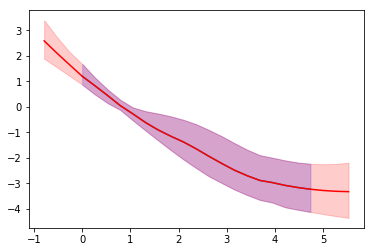

In [160]:
pre_eval_points = 10
post_eval_points = 3
num_points = 3
# get xs
diff = np.diff(x).mean()
pre_x = np.linspace(x.min()-num_points*diff, x.min()-diff, num_points)
post_x = np.linspace(x.max()+diff , x.max()+num_points*diff, num_points)

pre_y = lambda y : np.poly1d(np.polyfit(x[:pre_eval_points], y[:pre_eval_points], 2))(pre_x)
post_y = lambda y : np.poly1d(np.polyfit(x[-post_eval_points:], y[-post_eval_points:], 2))(post_x)
extend_y = lambda y : np.concatenate((pre_y(y), y, post_y(y)))

n_x = np.concatenate((pre_x, x, post_x))
n_y16 = extend_y(y16)
n_y50 = extend_y(y50)
n_y84 = extend_y(y84)

plt.plot(x, y50)
plt.fill_between(x, y16, y84, color='b', alpha=0.2)

plt.plot(n_x, n_y50, color='r')
plt.fill_between(n_x, n_y16, n_y84, color='r', alpha=0.2)

In [28]:
new_x = []
new_y = []

for i in sorted(np.unique(np.concatenate((x,_x)))):
    new_x.append(i)
    
    if i in x:
        new_y.append(y_50[x==i])
    else:
        new_y.append(mu[_x==i])

new_x = np.array(new_x)
new_y = np.array(new_y)[:,0]

plt.plot(new_x,new_y)
plt.fill_between(new_x, (new_y-k), (new_y+k), alpha=0.2, color='k')

In [35]:
def get_gp_img(Ie, Re, OverRe, x, y):
    pix = 0.06
    
    rs = []
    for i in range(84):
        for j in range(84):
            rs.append(np.sqrt((i-42)**2 + (j-42)**2)*pix)
    rs = sorted(np.unique(rs))
    
    Res = np.array([r/Re for r in rs if r/Re <= OverRe])
    
    data_with_noise = y + np.random.normal(scale=sigma_n, size=(len(y_50)))

    cov_f = lambda a,b: build_cov(a,b,sigma_n,sigma_f,length)
    cov_fn = lambda a,b: build_cov(a,b,sigma_n,sigma_f,length,with_sigma=True)

    
    def sample(self, X_, num_samples, return_var=False):
        mu, cov = self.predict(X_)
        samples = np.random.multivariate_normal(mu[:,0], cov, num_samples)
        
        return (samples, np.diag(cov)) if return_var else samples 

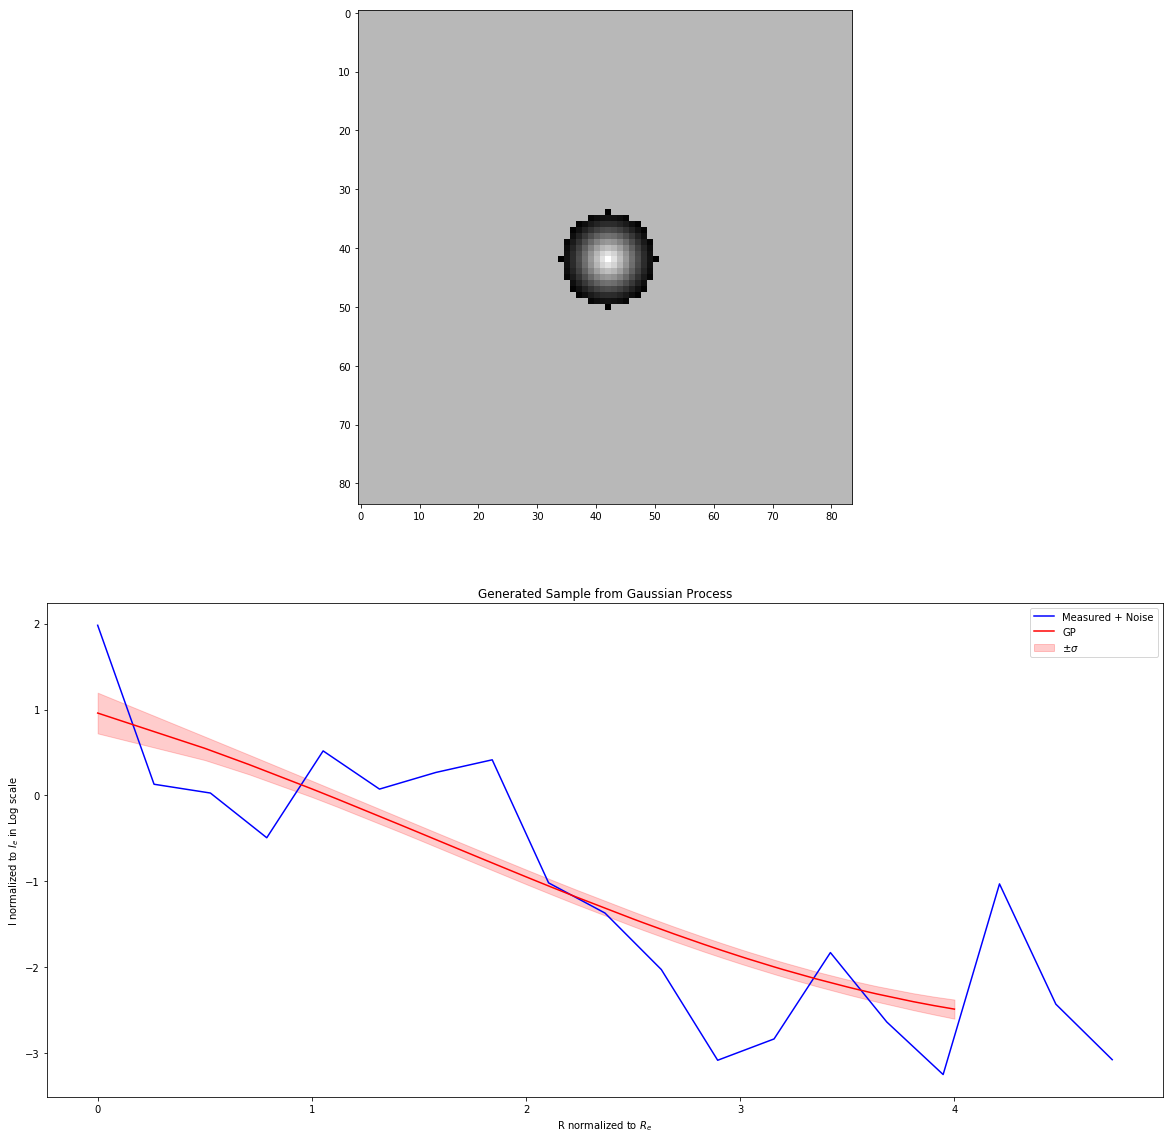

In [46]:
I0 = 1.0
Re = .12
OverRe = 2.5
pix = 0.06

# 0.3
length_scale = 1.0
alpha = 1.0
#kernel = lambda x, x_ : sigma_f * RBF(x, x_, length_scale)
kernel = lambda x, x_ : sigma_f * RQ(x, x_, length_scale, alpha) * RQ(x, x_, length_scale, alpha)

gp = GP(kernel, sigma_n)

X = n_x.reshape(n_x.shape[0],1)
Y = n_y50.reshape(n_y50.shape[0], 1)

gp.fit(X, Y)

num_points = 20
X_ = np.linspace(0, 4, num_points).reshape(num_points,1)

mu, cov = gp.predict(X_)
var = np.sqrt(np.diag(cov))

plt.plot(X_, mu)
plt.fill_between(X_[:,0], mu[:,0]-var, mu[:,0]+var, alpha=0.6)
plt.plot(X_,gp.sample(X_, 10).T, alpha=0.4)

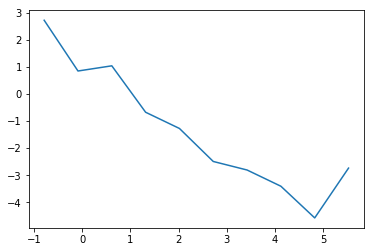

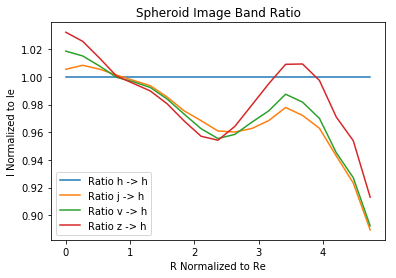

In [9]:
base = None

for b in ['h','j','v','z']:
    x, _, vals, _ = get_data('_orig_images_ClSph_{}.csv'.format(b))
    
    if base is None:
        base = vals
    
    plt.plot(x, vals/base, label='Ratio {} -> h'.format(b))

plt.legend()
plt.title('Spheroid Image Band Ratio')
plt.xlabel('R Normalized to Re')
plt.ylabel('I Normalized to Ie')